In [1]:
from astroquery.jplhorizons import Horizons
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as u
from astropy.time import Time

In [46]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate

In [71]:
import julian

TODO: try to test communication via socket

JPL and SIMBAD queries require different datetime format. I see two options

* Make a function that generates series separetly

or 

* Generate datetimes once and then treat them differently

# HORIZONS

In [67]:
epoch = datetime.datetime(2021,6,19,0,0,0)
dt = datetime.timedelta(seconds=1)

epochs=[]
for i in range(86400):
    epochs.append(epoch)
    epoch+= dt

    
# astropy.time.Time
JDs = Time(epochs)
JDs

<Time object: scale='utc' format='datetime' value=[datetime.datetime(2021, 6, 19, 0, 0)
 datetime.datetime(2021, 6, 19, 0, 0, 1)
 datetime.datetime(2021, 6, 19, 0, 0, 2) ...
 datetime.datetime(2021, 6, 19, 23, 59, 57)
 datetime.datetime(2021, 6, 19, 23, 59, 58)
 datetime.datetime(2021, 6, 19, 23, 59, 59)]>

In [4]:
# if no units supplied to 'step', it partitions the time difference into
# equal slices. For example, if 'start' and 'stop' differ by 10 hours,
# and 'step':100, then the dt will be 6 minutes.


# when the Horizons() method is supplied with a epochs dictionary,
# it just takes a long time

epochs_dict = {'start':'2021-06-17 00:00:00', 'stop':'2021-06-18 00:00:00', 'step':'4000'}

# if no epochs provided, epochs = current time
# epochs = None

using the epochs_dict dictionary allows much more values to be
downloaded. Approximate timing (on mobile data) here:

steps -- time (seconds)

* 1000 steps -- 5s
* 2000 steps -- 7s
* 3000 steps -- 8s
* 4000 steps -- 9s
* 5000 steps -- times out

I would suggest


* download a few (cca 200?) ephemeris, and find approximate times of crossing the $alt=15$ deg treshold

* donwload more (2000?) lines of ephemerides between rising and setting times

* interpolating between them to reach temporal precision of 1 second

In [35]:
# 557 = Ondrejov location code
obj = Horizons(id="Sun", location="557", epochs=epochs_dict, id_type="majorbody")
eph = obj.ephemerides()
eph

CPU times: user 689 ms, sys: 8.07 ms, total: 697 ms
Wall time: 696 ms


<Table masked=True length=4001>
targetname       datetime_str          datetime_jd    ...  PABLon  PABLat
   ---               ---                    d         ...   deg     deg  
   str8             str24                float64      ... float64 float64
---------- ------------------------ ----------------- ... ------- -------
  Sun (10) 2021-Jun-17 00:00:00.000         2459382.5 ... 85.7524 -0.0048
  Sun (10) 2021-Jun-17 00:00:21.600     2459382.50025 ... 85.7526 -0.0048
  Sun (10) 2021-Jun-17 00:00:43.200      2459382.5005 ... 85.7528 -0.0048
  Sun (10) 2021-Jun-17 00:01:04.800     2459382.50075 ... 85.7531 -0.0048
  Sun (10) 2021-Jun-17 00:01:26.400       2459382.501 ... 85.7533 -0.0048
  Sun (10) 2021-Jun-17 00:01:48.000     2459382.50125 ... 85.7536 -0.0048
  Sun (10) 2021-Jun-17 00:02:09.600      2459382.5015 ... 85.7538 -0.0048
  Sun (10) 2021-Jun-17 00:02:31.200     2459382.50175 ...  85.754 -0.0048
  Sun (10) 2021-Jun-17 00:02:52.800       2459382.502 ... 85.7543 -0.0048
       ...                      ...               ... ...     ...     ...
  Sun (10) 2021-Jun-17 23:56:45.600 2459383.497750001 ... 86.7049 -0.0049
  Sun (10) 2021-Jun-17 23:57:07.200 2459383.498000001 ... 86.7052 -0.0049
  Sun (10) 2021-Jun-17 23:57:28.800 2459383.498250001 ... 86.7054 -0.0049
  Sun (10) 2021-Jun-17 23:57:50.400 2459383.498500001 ... 86.7057 -0.0049
  Sun (10) 2021-Jun-17 23:58:12.000 2459383.498750001 ... 86.7059 -0.0049
  Sun (10) 2021-Jun-17 23:58:33.600 2459383.499000001 ... 86.7062 -0.0049
  Sun (10) 2021-Jun-17 23:58:55.200 2459383.499250001 ... 86.7064 -0.0049
  Sun (10) 2021-Jun-17 23:59:16.800 2459383.499500001 ... 86.7066 -0.0049
  Sun (10) 2021-Jun-17 23:59:38.400 2459383.499750001 ... 86.7069 -0.0049
  Sun (10) 2021-Jun-18 00:00:00.000         2459383.5 ... 86.7071 -0.0049

In [43]:
def interpol(time_input_axis, coord, time_output_axis):
    f = scipy.interpolate.interp1d(time_input_axis, coord)
    return f(time_output_axis)

In [77]:
julian_day = int(eph["datetime_jd"][0]) + 0.5


larger_time_axis = np.linspace(julian_day, julian_day + 1, 86400)

interpolated_EL = interpol(eph["datetime_jd"], eph["EL"], larger_time_axis)
interpolated_AZ = interpol(eph["datetime_jd"], eph["AZ"], larger_time_axis)


In [79]:
for i, jd in enumerate(larger_time_axis):
    print(julian.from_jd(jd), interpolated_EL[i], interpolated_AZ[i])

2021-06-17 00:00:00 -15.577044 13.859857
2021-06-17 00:00:00.999994 -15.576399142492331 13.86376980220947
2021-06-17 00:00:02.000029 -15.575754259039881 13.867682761844092
2021-06-17 00:00:03.000023 -15.575109401532213 13.871595564053562
2021-06-17 00:00:04.000058 -15.574464518079763 13.875508523688186
2021-06-17 00:00:05.000053 -15.573819660572093 13.879421325897654
2021-06-17 00:00:06.000088 -15.573174777119643 13.883334285532278
2021-06-17 00:00:07.000082 -15.572529919611974 13.887247087741748
2021-06-17 00:00:08.000077 -15.571885062104306 13.891159889951217
2021-06-17 00:00:09.000112 -15.571240178651856 13.89507284958584
2021-06-17 00:00:10.000106 -15.570595321144186 13.89898565179531
2021-06-17 00:00:11.000141 -15.569950437691736 13.902898611429933
2021-06-17 00:00:12.000136 -15.569305580184066 13.906811413639403
2021-06-17 00:00:13.000130 -15.568660722676396 13.910724215848873
2021-06-17 00:00:14.000165 -15.568015839223948 13.914637175483495
2021-06-17 00:00:15.000160 -15.5673709

2021-06-17 00:09:07.006326 -15.198874351788419 15.993613708864885
2021-06-17 00:09:08.006361 -15.198134187257274 15.997501436143878
2021-06-17 00:09:09.006356 -15.197394052504233 16.001389007012857
2021-06-17 00:09:10.006350 -15.196653917751192 16.005276577881837
2021-06-17 00:09:11.006385 -15.195913753220047 16.00916430516083
2021-06-17 00:09:12.006380 -15.195173618467006 16.01305187602981
2021-06-17 00:09:13.006415 -15.194433453935861 16.016939603308803
2021-06-17 00:09:14.006409 -15.19369331918282 16.020827174177782
2021-06-17 00:09:15.006404 -15.19295318442978 16.02471474504676
2021-06-17 00:09:16.006439 -15.192213019898634 16.028602472325755
2021-06-17 00:09:17.006433 -15.191472885145593 16.032490043194734
2021-06-17 00:09:18.006468 -15.190732720614449 16.036377770473727
2021-06-17 00:09:19.006462 -15.189992585861408 16.040265341342707
2021-06-17 00:09:20.006497 -15.189252421330263 16.0441530686217
2021-06-17 00:09:21.006492 -15.188512286577222 16.04804063949068
2021-06-17 00:09:2

2021-06-17 00:15:42.010903 -14.893193132188179 17.525357640438767
2021-06-17 00:15:43.010897 -14.89238540522025 17.52922530401158
2021-06-17 00:15:44.010932 -14.891577645754753 17.533093123193467
2021-06-17 00:15:45.010927 -14.890769918786821 17.536960786766283
2021-06-17 00:15:46.010962 -14.889962159321326 17.54082860594817
2021-06-17 00:15:47.010956 -14.889154432353395 17.544696269520983
2021-06-17 00:15:48.010991 -14.8883466728879 17.548564088702875
2021-06-17 00:15:49.010986 -14.88753894591997 17.552431752275687
2021-06-17 00:15:50.010980 -14.886731218952038 17.5562994158485
2021-06-17 00:15:51.011015 -14.885921196447564 17.56016652783071
2021-06-17 00:15:52.011010 -14.885109765796624 17.564033034002584
2021-06-17 00:15:53.011044 -14.88429830249911 17.567899695736966
2021-06-17 00:15:54.011039 -14.883486871848172 17.57176620190884
2021-06-17 00:15:55.011034 -14.882675441197234 17.575632708080715
2021-06-17 00:15:56.011068 -14.88186397789972 17.579499369815096
2021-06-17 00:15:57.01

2021-06-17 00:24:18.016875 -14.453349870929888 19.513747292770518
2021-06-17 00:24:19.016869 -14.452453487049961 19.51758620650398
2021-06-17 00:24:20.016904 -14.451557067105506 19.521425274689822
2021-06-17 00:24:21.016899 -14.450660683225578 19.52526418842329
2021-06-17 00:24:22.016934 -14.449764263281123 19.52910325660913
2021-06-17 00:24:23.016928 -14.448867879401197 19.532942170342597
2021-06-17 00:24:24.016963 -14.44797145945674 19.536781238528437
2021-06-17 00:24:25.016958 -14.447075075576814 19.540620152261905
2021-06-17 00:24:26.016952 -14.446178691696888 19.54445906599537
2021-06-17 00:24:27.016987 -14.445282271752431 19.54829813418121
2021-06-17 00:24:28.016982 -14.444385887872505 19.552137047914677
2021-06-17 00:24:29.017016 -14.443488674206652 19.555975844828648
2021-06-17 00:24:30.017011 -14.442588632939756 19.5598135085691
2021-06-17 00:24:31.017006 -14.44168859167286 19.56365117230955
2021-06-17 00:24:32.017040 -14.440788514194285 19.567488990452084
2021-06-17 00:24:33.

2021-06-17 00:32:20.022468 -14.001732692993288 21.357280226104596
2021-06-17 00:32:21.022463 -14.000756541040586 21.361090806663054
2021-06-17 00:32:22.022457 -13.999780389087881 21.36490138722151
2021-06-17 00:32:23.022492 -13.998804197861311 21.368712121092404
2021-06-17 00:32:24.022487 -13.997827965734785 21.372522672496746
2021-06-17 00:32:25.022521 -13.996848209569896 21.376332110026432
2021-06-17 00:32:26.022516 -13.995868492822298 21.380141394295837
2021-06-17 00:32:27.022551 -13.994888736657408 21.383950831825523
2021-06-17 00:32:28.022545 -13.993909019909811 21.387760116094928
2021-06-17 00:32:29.022540 -13.992929303162212 21.391569400364336
2021-06-17 00:32:30.022575 -13.991949546997324 21.39537883789402
2021-06-17 00:32:31.022569 -13.990969830249725 21.399188122163427
2021-06-17 00:32:32.022604 -13.989990074084835 21.402997559693112
2021-06-17 00:32:33.022599 -13.989010357337238 21.406806843962517
2021-06-17 00:32:34.022634 -13.988030601172348 21.410616281492203
2021-06-17 0

2021-06-17 00:41:29.028824 -13.440363544806853 23.439635792531167
2021-06-17 00:41:30.028819 -13.439295217443297 23.443410771436714
2021-06-17 00:41:31.028814 -13.43822689007974 23.44718575034226
2021-06-17 00:41:32.028848 -13.43715851973379 23.45096088112787
2021-06-17 00:41:33.028843 -13.436090192370234 23.454735860033416
2021-06-17 00:41:34.028878 -13.435021822024286 23.458510990819025
2021-06-17 00:41:35.028872 -13.433953494660729 23.462285969724572
2021-06-17 00:41:36.028907 -13.43288512431478 23.466061100510178
2021-06-17 00:41:37.028902 -13.431816796951223 23.469836079415725
2021-06-17 00:41:38.028896 -13.430748469587666 23.473611058321275
2021-06-17 00:41:39.028931 -13.429680099241718 23.47738618910688
2021-06-17 00:41:40.028926 -13.428611771878161 23.481161168012427
2021-06-17 00:41:41.028960 -13.427543401532212 23.484936298798036
2021-06-17 00:41:42.028955 -13.426475074168655 23.488711277703583
2021-06-17 00:41:43.028990 -13.425406703822706 23.492486408489192
2021-06-17 00:41

2021-06-17 00:50:09.034815 -12.863556066399564 25.39387832090204
2021-06-17 00:50:10.034850 -12.862404683918482 25.39761877456037
2021-06-17 00:50:11.034844 -12.861253347759517 25.40135907773376
2021-06-17 00:50:12.034879 -12.860101965278437 25.405099531392086
2021-06-17 00:50:13.034874 -12.858950629119471 25.408839834565473
2021-06-17 00:50:14.034868 -12.857799292960506 25.41258013773886
2021-06-17 00:50:15.034903 -12.856647910479426 25.416320591397188
2021-06-17 00:50:16.034898 -12.85549657432046 25.420060894570575
2021-06-17 00:50:17.034932 -12.85434519183938 25.423801348228906
2021-06-17 00:50:18.034927 -12.853193855680415 25.427541651402294
2021-06-17 00:50:19.034962 -12.852042473199335 25.43128210506062
2021-06-17 00:50:20.034956 -12.85089113704037 25.43502240823401
2021-06-17 00:50:21.034951 -12.849739800881403 25.438762711407396
2021-06-17 00:50:22.034986 -12.848588418400324 25.442503165065723
2021-06-17 00:50:23.034980 -12.847437082241358 25.446243468239114
2021-06-17 00:50:24

2021-06-17 00:59:27.041283 -12.197052882325549 27.47036319906458
2021-06-17 00:59:28.041278 -12.195813907767414 27.474064289494123
2021-06-17 00:59:29.041313 -12.19457488336118 27.477765528830947
2021-06-17 00:59:30.041307 -12.193335908803045 27.48146661926049
2021-06-17 00:59:31.041342 -12.19209688439681 27.48516785859732
2021-06-17 00:59:32.041337 -12.190857909838677 27.488868949026863
2021-06-17 00:59:33.041372 -12.18961888543244 27.492570188363686
2021-06-17 00:59:34.041366 -12.188379910874307 27.49627127879323
2021-06-17 00:59:35.041361 -12.187140936316172 27.499972369222775
2021-06-17 00:59:36.041395 -12.185901911909937 27.5036736085596
2021-06-17 00:59:37.041390 -12.184662937351803 27.507374698989143
2021-06-17 00:59:38.041425 -12.183423912945567 27.511075938325966
2021-06-17 00:59:39.041419 -12.182184938387433 27.51477702875551
2021-06-17 00:59:40.041454 -12.180945913981198 27.518478268092334
2021-06-17 00:59:41.041449 -12.179706939423063 27.52217935852188
2021-06-17 00:59:42.0

2021-06-17 01:07:56.047173 -11.54728224069283 29.34522218297692
2021-06-17 01:07:57.047207 -11.545967935900803 29.348887587738954
2021-06-17 01:07:58.047202 -11.544653683985539 29.3525528450354
2021-06-17 01:07:59.047197 -11.543339432070274 29.356218102331844
2021-06-17 01:08:00.047231 -11.542025127278247 29.359883507093883
2021-06-17 01:08:01.047226 -11.540710875362983 29.36354876439033
2021-06-17 01:08:02.047261 -11.539396570570956 29.367214169152366
2021-06-17 01:08:03.047255 -11.538080191053345 29.370878377630753
2021-06-17 01:08:04.047250 -11.53676265211941 29.374542014565883
2021-06-17 01:08:05.047285 -11.535445060176468 29.378205798901412
2021-06-17 01:08:06.047279 -11.534127521242533 29.381869435836542
2021-06-17 01:08:07.047314 -11.53280992929959 29.38553322017207
2021-06-17 01:08:08.047309 -11.531492390365656 29.3891968571072
2021-06-17 01:08:09.047344 -11.530174798422712 29.39286064144273
2021-06-17 01:08:10.047338 -11.52885725948878 29.39652427837786
2021-06-17 01:08:11.047

2021-06-17 01:17:45.053996 -10.747105481137925 31.491107328777304
2021-06-17 01:17:46.053991 -10.745703941861265 31.494728677255804
2021-06-17 01:17:47.054025 -10.744300652504977 31.49834931194831
2021-06-17 01:17:48.054020 -10.742897419605454 31.5019698009764
2021-06-17 01:17:49.054055 -10.741494130249166 31.505590435668903
2021-06-17 01:17:50.054049 -10.740090897349642 31.509210924696994
2021-06-17 01:17:51.054044 -10.738687664450119 31.512831413725085
2021-06-17 01:17:52.054079 -10.73728437509383 31.51645204841759
2021-06-17 01:17:53.054073 -10.735881142194307 31.52007253744568
2021-06-17 01:17:54.054108 -10.734477852838019 31.523693172138184
2021-06-17 01:17:55.054103 -10.733074619938495 31.527313661166275
2021-06-17 01:17:56.054137 -10.731671330582206 31.53093429585878
2021-06-17 01:17:57.054132 -10.730268097682682 31.534554784886872
2021-06-17 01:17:58.054127 -10.728864864783159 31.538175273914963
2021-06-17 01:17:59.054161 -10.72746157542687 31.54179590860747
2021-06-17 01:18:00

2021-06-17 01:26:24.059992 -10.000395401655146 33.36048584168264
2021-06-17 01:26:25.060027 -9.998918406041675 33.36406740094734
2021-06-17 01:26:26.060021 -9.9974414698503 33.3676488161197
2021-06-17 01:26:27.060016 -9.995964533658924 33.37123023129206
2021-06-17 01:26:28.060051 -9.994487538045453 33.37481179055676
2021-06-17 01:26:29.060045 -9.993010601854076 33.37839320572912
2021-06-17 01:26:30.060080 -9.991533606240605 33.38197476499382
2021-06-17 01:26:31.060075 -9.99005667004923 33.38555618016618
2021-06-17 01:26:32.060109 -9.988579674435758 33.389137739430886
2021-06-17 01:26:33.060104 -9.987102738244383 33.39271915460324
2021-06-17 01:26:34.060099 -9.985625802053008 33.396300569775605
2021-06-17 01:26:35.060133 -9.984148806439535 33.39988212904031
2021-06-17 01:26:36.060128 -9.98267187024816 33.40346354421267
2021-06-17 01:26:37.060163 -9.981194874634689 33.40704510347737
2021-06-17 01:26:38.060157 -9.979717938443313 33.41062651864973
2021-06-17 01:26:39.060192 -9.978240942829

2021-06-17 01:35:21.066212 -9.188081635754212 35.273222508487144
2021-06-17 01:35:22.066247 -9.18653320248067 35.27676462194084
2021-06-17 01:35:23.066242 -9.184984831503284 35.28030659288917
2021-06-17 01:35:24.066236 -9.183436267373354 35.28384845653053
2021-06-17 01:35:25.066271 -9.181884917332097 35.287388949557716
2021-06-17 01:35:26.066266 -9.180333629704343 35.290929300144725
2021-06-17 01:35:27.066300 -9.178782279663084 35.29446979317192
2021-06-17 01:35:28.066295 -9.17723099203533 35.29801014375893
2021-06-17 01:35:29.066289 -9.175679704407576 35.30155049434594
2021-06-17 01:35:30.066324 -9.174128354366319 35.305090987373134
2021-06-17 01:35:31.066319 -9.172577066738565 35.30863133796014
2021-06-17 01:35:32.066354 -9.171025716697308 35.31217183098733
2021-06-17 01:35:33.066348 -9.169474429069552 35.31571218157435
2021-06-17 01:35:34.066383 -9.167923079028295 35.319252674601536
2021-06-17 01:35:35.066378 -9.166371791400541 35.322793025188545
2021-06-17 01:35:36.066372 -9.164820

2021-06-17 01:43:58.072219 -8.369126610856238 37.09395309073688
2021-06-17 01:43:59.072214 -8.367509258782835 37.097455524869105
2021-06-17 01:44:00.072208 -8.365891906709432 37.10095795900132
2021-06-17 01:44:01.072243 -8.364274489564531 37.104460534048215
2021-06-17 01:44:02.072238 -8.362657137491128 37.10796296818044
2021-06-17 01:44:03.072272 -8.361037788695587 37.11146442718535
2021-06-17 01:44:04.072267 -8.359417563249949 37.114965201180915
2021-06-17 01:44:05.072261 -8.357797337804309 37.118465975176484
2021-06-17 01:44:06.072296 -8.356177047171569 37.12196689001993
2021-06-17 01:44:07.072291 -8.354556821725929 37.125467664015495
2021-06-17 01:44:08.072326 -8.352936531093189 37.12896857885894
2021-06-17 01:44:09.072320 -8.351316305647549 37.13246935285451
2021-06-17 01:44:10.072355 -8.349696015014807 37.13597026769795
2021-06-17 01:44:11.072350 -8.348075789569169 37.13947104169352
2021-06-17 01:44:12.072344 -8.34645556412353 37.14297181568909
2021-06-17 01:44:13.072379 -8.344835

2021-06-17 01:53:07.078535 -7.461241850377466 39.00506526540454
2021-06-17 01:53:08.078570 -7.45955234740189 39.008525061191605
2021-06-17 01:53:09.078564 -7.4578629123979505 39.01198471778509
2021-06-17 01:53:10.078599 -7.456173409422376 39.01544451357216
2021-06-17 01:53:11.078594 -7.454483974418436 39.01890417016564
2021-06-17 01:53:12.078629 -7.452794471442861 39.022363965952714
2021-06-17 01:53:13.078623 -7.451105036438921 39.0258236225462
2021-06-17 01:53:14.078618 -7.449415601434982 39.02928327913968
2021-06-17 01:53:15.078653 -7.447726098459407 39.03274307492675
2021-06-17 01:53:16.078647 -7.446036663455467 39.036202731520234
2021-06-17 01:53:17.078682 -7.444347160479892 39.03966252730731
2021-06-17 01:53:18.078677 -7.442657725475953 39.04312218390079
2021-06-17 01:53:19.078711 -7.440968222500378 39.04658197968786
2021-06-17 01:53:20.078706 -7.439278787496438 39.05004163628134
2021-06-17 01:53:21.078701 -7.437589352492498 39.05350129287483
2021-06-17 01:53:22.078735 -7.43589984

2021-06-17 02:01:51.084625 -6.55928518042323 40.807831161072215
2021-06-17 02:01:52.084619 -6.557531717999296 40.81125169751393
2021-06-17 02:01:53.084654 -6.555778185027688 40.8146723715753
2021-06-17 02:01:54.084649 -6.554024722603754 40.81809290801701
2021-06-17 02:01:55.084683 -6.552271189632146 40.821513582078374
2021-06-17 02:01:56.084678 -6.550517727208212 40.82493411852009
2021-06-17 02:01:57.084673 -6.548764264784277 40.82835465496181
2021-06-17 02:01:58.084707 -6.547010731812669 40.83177532902317
2021-06-17 02:01:59.084702 -6.545257269388736 40.83519586546489
2021-06-17 02:02:00.084737 -6.543503736417128 40.83861653952626
2021-06-17 02:02:01.084731 -6.541750273993194 40.84203707596797
2021-06-17 02:02:02.084726 -6.539996811569259 40.84545761240969
2021-06-17 02:02:03.084761 -6.538241471571383 40.84887720859573
2021-06-17 02:02:04.084755 -6.536485370273305 40.852296170972174
2021-06-17 02:02:05.084790 -6.534729198321384 40.85571527090493
2021-06-17 02:02:06.084785 -6.532973097

2021-06-17 02:11:13.091112 -5.554964201716986 42.71846457457751
2021-06-17 02:11:14.091146 -5.553143953471132 42.72184353423076
2021-06-17 02:11:15.091141 -5.551323778457022 42.7252223579426
2021-06-17 02:11:16.091176 -5.549503530211168 42.728601317595846
2021-06-17 02:11:17.091170 -5.547683355197059 42.73198014130769
2021-06-17 02:11:18.091165 -5.545863180182949 42.73535896501953
2021-06-17 02:11:19.091200 -5.544042931937095 42.73873792467278
2021-06-17 02:11:20.091194 -5.542222756922985 42.742116748384625
2021-06-17 02:11:21.091229 -5.540402508677131 42.74549570803787
2021-06-17 02:11:22.091224 -5.5385823336630216 42.74887453174971
2021-06-17 02:11:23.091259 -5.536762085417167 42.75225349140297
2021-06-17 02:11:24.091253 -5.534941682281219 42.75563216725806
2021-06-17 02:11:25.091248 -5.533119007281079 42.75900937060858
2021-06-17 02:11:26.091282 -5.531296258948611 42.762386709835326
2021-06-17 02:11:27.091277 -5.529473583948472 42.76576391318585
2021-06-17 02:11:28.091312 -5.5276508

2021-06-17 02:19:01.096539 -4.690548090943635 44.291763014221296
2021-06-17 02:19:02.096534 -4.688673703269501 44.29510716220098
2021-06-17 02:19:03.096569 -4.686799240182465 44.29845144472694
2021-06-17 02:19:04.096563 -4.684924852508331 44.301795592706625
2021-06-17 02:19:05.096598 -4.683050389421295 44.3051398752326
2021-06-17 02:19:06.096593 -4.681176001747161 44.30848402321228
2021-06-17 02:19:07.096627 -4.679301538660125 44.31182830573825
2021-06-17 02:19:08.096622 -4.6774271509859915 44.315172453717935
2021-06-17 02:19:09.096617 -4.675552763311857 44.31851660169762
2021-06-17 02:19:10.096651 -4.673678300224822 44.32186088422358
2021-06-17 02:19:11.096646 -4.671803912550687 44.325205032203264
2021-06-17 02:19:12.096681 -4.669929449463652 44.32854931472924
2021-06-17 02:19:13.096675 -4.668055061789517 44.33189346270892
2021-06-17 02:19:14.096710 -4.666180598702482 44.335237745234885
2021-06-17 02:19:15.096705 -4.6643062110283475 44.33858189321457
2021-06-17 02:19:16.096699 -4.6624

2021-06-17 02:28:25.103056 -3.6162701424029238 46.16681791736562
2021-06-17 02:28:26.103090 -3.614334149406468 46.170122244803686
2021-06-17 02:28:27.103085 -3.61239823429837 46.17342643930292
2021-06-17 02:28:28.103120 -3.610462241301914 46.17673076674099
2021-06-17 02:28:29.103114 -3.6085263261938154 46.180034961240224
2021-06-17 02:28:30.103109 -3.606590411085717 46.18333915573946
2021-06-17 02:28:31.103144 -3.6046544180892615 46.18664348317753
2021-06-17 02:28:32.103138 -3.602718502981163 46.18994767767676
2021-06-17 02:28:33.103173 -3.6007825099847075 46.19325200511482
2021-06-17 02:28:34.103168 -3.598846594876609 46.19655619961406
2021-06-17 02:28:35.103203 -3.5969106018801535 46.199860527052124
2021-06-17 02:28:36.103197 -3.594974686772055 46.20316472155136
2021-06-17 02:28:37.103192 -3.5930387716639562 46.206468916050596
2021-06-17 02:28:38.103227 -3.591102778667501 46.20977324348866
2021-06-17 02:28:39.103221 -3.5891668635594023 46.2130774379879
2021-06-17 02:28:40.103256 -3.5

2021-06-17 02:37:15.109193 -2.5756608762048985 47.90852025521774
2021-06-17 02:37:16.109228 -2.5736705294735605 47.91178884067681
2021-06-17 02:37:17.109223 -2.5716802628173245 47.91505729463503
2021-06-17 02:37:18.109217 -2.569689996161089 47.91832574859324
2021-06-17 02:37:19.109252 -2.567699649429751 47.921594334052315
2021-06-17 02:37:20.109246 -2.5657073588913515 47.92486148863226
2021-06-17 02:37:21.109281 -2.563714786149347 47.92812864494198
2021-06-17 02:37:22.109276 -2.5617222935720005 47.93139566980833
2021-06-17 02:37:23.109311 -2.559729720829996 47.93466282611806
2021-06-17 02:37:24.109305 -2.5577372282526496 47.93792985098441
2021-06-17 02:37:25.109300 -2.555744735675303 47.941196875850764
2021-06-17 02:37:26.109335 -2.5537521629332987 47.94446403216049
2021-06-17 02:37:27.109329 -2.551759670355952 47.94773105702684
2021-06-17 02:37:28.109364 -2.5497670976139477 47.95099821333656
2021-06-17 02:37:29.109359 -2.5477746050366012 47.954265238202915
2021-06-17 02:37:30.109393 -

2021-06-17 02:46:28.115608 -1.4591959338220912 49.705543187825384
2021-06-17 02:46:29.115603 -1.457149417480177 49.70877437347333
2021-06-17 02:46:30.115638 -1.455102818800047 49.71200568912271
2021-06-17 02:46:31.115632 -1.4530563024581324 49.71523687477066
2021-06-17 02:46:32.115667 -1.4510097037780025 49.71846819042005
2021-06-17 02:46:33.115662 -1.448963187436088 49.721699376067996
2021-06-17 02:46:34.115656 -1.4469166710941734 49.724930561715944
2021-06-17 02:46:35.115691 -1.4448700724140437 49.72816187736533
2021-06-17 02:46:36.115685 -1.4428235560721292 49.73139306301328
2021-06-17 02:46:37.115720 -1.4407769573919993 49.73462437866266
2021-06-17 02:46:38.115715 -1.4387304410500847 49.73785556431061
2021-06-17 02:46:39.115750 -1.4366838423699548 49.741086879959994
2021-06-17 02:46:40.115744 -1.4346373260280403 49.74431806560794
2021-06-17 02:46:41.115739 -1.4325901226383992 49.74754881271479
2021-06-17 02:46:42.115774 -1.430541347956958 49.75077873942716
2021-06-17 02:46:43.11576

2021-06-17 02:55:24.121794 -0.34848510848974895 51.42836871826193
2021-06-17 02:55:25.121828 -0.3463868413529507 51.43156577346513
2021-06-17 02:55:26.121823 -0.34428865863307945 51.43476270004526
2021-06-17 02:55:27.121858 -0.3421903914962813 51.437959755248464
2021-06-17 02:55:28.121852 -0.34009220877641 51.441156681828595
2021-06-17 02:55:29.121847 -0.3379940260565387 51.44435360840872
2021-06-17 02:55:30.121882 -0.3358957589197405 51.44755066361193
2021-06-17 02:55:31.121876 -0.3337975761998693 51.45074759019206
2021-06-17 02:55:32.121911 -0.33169930906307105 51.45394464539526
2021-06-17 02:55:33.121906 -0.32960112634319977 51.45714157197539
2021-06-17 02:55:34.121941 -0.32750285920640154 51.460338627178594
2021-06-17 02:55:35.121935 -0.3254046764865303 51.463535553758724
2021-06-17 02:55:36.121930 -0.32330649376665904 51.46673248033885
2021-06-17 02:55:37.121964 -0.3212082266298608 51.46992953554206
2021-06-17 02:55:38.121959 -0.3191100439099896 51.47312646212218
2021-06-17 02:55:

2021-06-17 03:03:52.127688 0.7289782576876009 53.04475775479212
2021-06-17 03:03:53.127683 0.7311217179322408 53.04792463524385
2021-06-17 03:03:54.127718 0.7332652644154741 53.0510916431098
2021-06-17 03:03:55.127712 0.7354087246601139 53.05425852356153
2021-06-17 03:03:56.127747 0.7375522711433473 53.05742553142748
2021-06-17 03:03:57.127742 0.739695731387987 53.060592411879206
2021-06-17 03:03:58.127736 0.7418402177897484 53.063758657090816
2021-06-17 03:03:59.127771 0.7439857087847919 53.06692446121136
2021-06-17 03:04:00.127766 0.7461311134630106 53.070090137966105
2021-06-17 03:04:01.127800 0.7482766044580542 53.07325594208665
2021-06-17 03:04:02.127795 0.750422009136273 53.0764216188414
2021-06-17 03:04:03.127830 0.7525675001313165 53.07958742296194
2021-06-17 03:04:04.127824 0.7547129048095352 53.0827530997167
2021-06-17 03:04:05.127819 0.756858309487754 53.085918776471445
2021-06-17 03:04:06.127854 0.7590038004827976 53.08908458059199
2021-06-17 03:04:07.127848 0.7611492051610

2021-06-17 03:11:36.133057 1.7332465172601985 54.507856451818036
2021-06-17 03:11:37.133052 1.7354314587545239 54.51099615649569
2021-06-17 03:11:38.133087 1.737616488156373 54.5141359874942
2021-06-17 03:11:39.133081 1.7398014296506983 54.517275692171864
2021-06-17 03:11:40.133116 1.7419864590525471 54.52041552317037
2021-06-17 03:11:41.133111 1.7441714005468725 54.52355522784803
2021-06-17 03:11:42.133145 1.7463564299487215 54.52669505884654
2021-06-17 03:11:43.133140 1.7485413714430469 54.5298347635242
2021-06-17 03:11:44.133135 1.7507263129373722 54.53297446820186
2021-06-17 03:11:45.133169 1.752911342339221 54.53611429920037
2021-06-17 03:11:46.133164 1.7550962838335467 54.53925400387803
2021-06-17 03:11:47.133199 1.7572813132353955 54.542393834876535
2021-06-17 03:11:48.133193 1.7594662547297208 54.54553353955419
2021-06-17 03:11:49.133188 1.7616511962240464 54.54867324423186
2021-06-17 03:11:50.133223 1.7638362256258953 54.55181307523036
2021-06-17 03:11:51.133217 1.766021167120

2021-06-17 03:20:29.139219 2.909485465262605 56.17374453620143
2021-06-17 03:20:30.139254 2.9117135980095776 56.1768563106724
2021-06-17 03:20:31.139248 2.9139416411149046 56.17996795995128
2021-06-17 03:20:32.139243 2.916171380074543 56.18307860911094
2021-06-17 03:20:33.139277 2.918401318439625 56.1861893187302
2021-06-17 03:20:34.139272 2.920631167090418 56.18929990320021
2021-06-17 03:20:35.139307 2.9228611054555005 56.192410612819465
2021-06-17 03:20:36.139301 2.9250909541062935 56.19552119728948
2021-06-17 03:20:37.139336 2.927320892471376 56.19863190690874
2021-06-17 03:20:38.139331 2.929550741122169 56.20174249137875
2021-06-17 03:20:39.139325 2.931780589772962 56.20485307584876
2021-06-17 03:20:40.139360 2.934010528138044 56.20796378546802
2021-06-17 03:20:41.139355 2.936240376788837 56.21107436993803
2021-06-17 03:20:42.139390 2.9384703151539195 56.21418507955729
2021-06-17 03:20:43.139384 2.9407001638047126 56.2172956640273
2021-06-17 03:20:44.139419 2.942930102169795 56.220

2021-06-17 03:31:20.146752 4.377266283917366 58.18848254894752
2021-06-17 03:31:21.146787 4.379547057376912 58.1915610815261
2021-06-17 03:31:22.146781 4.381827739076985 58.19463949024999
2021-06-17 03:31:23.146776 4.384108420777058 58.19771789897387
2021-06-17 03:31:24.146811 4.386389194236604 58.20079643155246
2021-06-17 03:31:25.146805 4.388669875936677 58.20387484027634
2021-06-17 03:31:26.146840 4.390950649396223 58.20695337285493
2021-06-17 03:31:27.146835 4.393231331096296 58.21003178157882
2021-06-17 03:31:28.146869 4.395512104555843 58.213110314157404
2021-06-17 03:31:29.146864 4.397792786255916 58.21618872288129
2021-06-17 03:31:30.146858 4.400073467955989 58.21926713160517
2021-06-17 03:31:31.146893 4.402354241415535 58.22234566418376
2021-06-17 03:31:32.146888 4.404634923115609 58.22542407290765
2021-06-17 03:31:33.146923 4.406915696575155 58.228502605486234
2021-06-17 03:31:34.146917 4.409196378275228 58.23158101421012
2021-06-17 03:31:35.146952 4.411477151734774 58.234659

2021-06-17 03:40:34.153161 5.6517999585002725 59.88718176670001
2021-06-17 03:40:35.153196 5.654120548154026 59.890235992880974
2021-06-17 03:40:36.153191 5.6564410444464315 59.89329009618512
2021-06-17 03:40:37.153226 5.658761634100184 59.89634432236608
2021-06-17 03:40:38.153220 5.66108213039259 59.89939842567023
2021-06-17 03:40:39.153215 5.663402626684995 59.90245252897437
2021-06-17 03:40:40.153250 5.665723216338748 59.905506755155336
2021-06-17 03:40:41.153244 5.6680442686678925 59.908560531379045
2021-06-17 03:40:42.153279 5.670366432450254 59.911613831602004
2021-06-17 03:40:43.153274 5.6726885028079375 59.9146670089854
2021-06-17 03:40:44.153308 5.675010666590298 59.917720309208356
2021-06-17 03:40:45.153303 5.677332736947982 59.92077348659175
2021-06-17 03:40:46.153298 5.679654807305665 59.92382666397515
2021-06-17 03:40:47.153332 5.681976971088027 59.92687996419811
2021-06-17 03:40:48.153327 5.68429904144571 59.9299331415815
2021-06-17 03:40:49.153362 5.686621205228072 59.93

2021-06-17 03:48:00.158346 6.693926173581736 61.24511870327509
2021-06-17 03:48:01.158341 6.696278475251969 61.24815424186816
2021-06-17 03:48:02.158376 6.6986308715631875 61.25118990259113
2021-06-17 03:48:03.158370 6.700983173233421 61.2542254411842
2021-06-17 03:48:04.158365 6.703335474903654 61.257260979777264
2021-06-17 03:48:05.158400 6.705687871214873 61.260296640500236
2021-06-17 03:48:06.158394 6.708040172885107 61.263332179093304
2021-06-17 03:48:07.158429 6.710392569196324 61.26636783981627
2021-06-17 03:48:08.158424 6.712744870866558 61.26940337840934
2021-06-17 03:48:09.158459 6.715097267177776 61.27243903913231
2021-06-17 03:48:10.158453 6.71744956884801 61.275474577725376
2021-06-17 03:48:11.158448 6.719801870518244 61.278510116318444
2021-06-17 03:48:12.158482 6.722154266829461 61.281545777041416
2021-06-17 03:48:13.158477 6.724506568499695 61.28458131563448
2021-06-17 03:48:14.158512 6.726858964810913 61.28761697635745
2021-06-17 03:48:15.158506 6.729212390207331 61.29

2021-06-17 03:57:08.164668 7.992939396223674 62.9030538604581
2021-06-17 03:57:09.164703 7.995327580811778 62.90606970567976
2021-06-17 03:57:10.164697 7.997715669319073 62.90908542956874
2021-06-17 03:57:11.164732 8.000103853907177 62.91210127479041
2021-06-17 03:57:12.164727 8.002491942414473 62.91511699867939
2021-06-17 03:57:13.164721 8.004880030921766 62.918132722568366
2021-06-17 03:57:14.164756 8.007268215509871 62.92114856779003
2021-06-17 03:57:15.164751 8.009657401576915 62.9241636897914
2021-06-17 03:57:16.164785 8.012047021399926 62.927178747948766
2021-06-17 03:57:17.164780 8.014436545084386 62.930193684805104
2021-06-17 03:57:18.164775 8.016826068768848 62.93320862166144
2021-06-17 03:57:19.164809 8.01921568859186 62.9362236798188
2021-06-17 03:57:20.164804 8.02160521227632 62.93923861667514
2021-06-17 03:57:21.164839 8.023994832099332 62.9422536748325
2021-06-17 03:57:22.164833 8.026384355783792 62.94526861168884
2021-06-17 03:57:23.164868 8.028773975606804 62.9482836698

2021-06-17 04:06:10.170941 9.296733830897926 64.53270707003358
2021-06-17 04:06:11.170976 9.299155766655305 64.53570569243637
2021-06-17 04:06:12.170971 9.301577604974007 64.53870419419935
2021-06-17 04:06:13.170965 9.30399944329271 64.54170269596234
2021-06-17 04:06:14.171000 9.30642137905009 64.54470131836513
2021-06-17 04:06:15.170995 9.308844181103096 64.54769928472017
2021-06-17 04:06:16.171030 9.311267366903781 64.55069721265444
2021-06-17 04:06:17.171024 9.313690455215498 64.55369501997687
2021-06-17 04:06:18.171059 9.316113641016186 64.55669294791115
2021-06-17 04:06:19.171054 9.318536729327903 64.55969075523358
2021-06-17 04:06:20.171048 9.32095981763962 64.56268856255599
2021-06-17 04:06:21.171083 9.323383003440306 64.56568649049026
2021-06-17 04:06:22.171078 9.325806091752023 64.5686842978127
2021-06-17 04:06:23.171112 9.328229277552708 64.57168222574697
2021-06-17 04:06:24.171107 9.330652365864426 64.5746800330694
2021-06-17 04:06:25.171142 9.333075551665113 64.577677961003

2021-06-17 04:15:24.177351 10.647714734275088 66.18955385770697
2021-06-17 04:15:25.177386 10.650169448945837 66.19253747959007
2021-06-17 04:15:26.177380 10.652624064859157 66.19552098143689
2021-06-17 04:15:27.177415 10.655078779529907 66.19850460331998
2021-06-17 04:15:28.177410 10.657533395443226 66.20148810516679
2021-06-17 04:15:29.177404 10.659988011356546 66.2044716070136
2021-06-17 04:15:30.177439 10.662442726027296 66.2074552288967
2021-06-17 04:15:31.177434 10.664897341940616 66.21043873074352
2021-06-17 04:15:32.177469 10.667352056611366 66.21342235262661
2021-06-17 04:15:33.177463 10.669806672524686 66.21640585447342
2021-06-17 04:15:34.177498 10.672261387195435 66.21938947635653
2021-06-17 04:15:35.177493 10.674716003108754 66.22237297820334
2021-06-17 04:15:36.177487 10.677170833453165 66.22535638244268
2021-06-17 04:15:37.177522 10.679626756443833 66.22833945430737
2021-06-17 04:15:38.177517 10.682082580628459 66.23132240615791
2021-06-17 04:15:39.177551 10.684538503619

2021-06-17 04:24:19.183542 11.968803491101214 67.78257169026638
2021-06-17 04:24:20.183577 11.971287604938617 67.78554378397232
2021-06-17 04:24:21.183571 11.97377161883581 67.78851575810576
2021-06-17 04:24:22.183606 11.976255732673211 67.7914878518117
2021-06-17 04:24:23.183601 11.978739746570405 67.79445982594515
2021-06-17 04:24:24.183595 11.981223760467598 67.7974318000786
2021-06-17 04:24:25.183630 11.983707874305 67.80040389378453
2021-06-17 04:24:26.183625 11.986191888202194 67.80337586791799
2021-06-17 04:24:27.183659 11.988676002039597 67.80634796162393
2021-06-17 04:24:28.183654 11.991160015936789 67.80931993575737
2021-06-17 04:24:29.183689 11.993644129774191 67.81229202946331
2021-06-17 04:24:30.183683 11.996128143671385 67.81526400359677
2021-06-17 04:24:31.183678 11.998612157568578 67.81823597773021
2021-06-17 04:24:32.183713 12.00109627140598 67.82120807143615
2021-06-17 04:24:33.183707 12.003580285303174 67.8241800455696
2021-06-17 04:24:34.183742 12.006064399140575 67

2021-06-17 04:33:39.190040 13.367742839209047 69.44434772224612
2021-06-17 04:33:40.190034 13.370255278873325 69.44731090013244
2021-06-17 04:33:41.190069 13.372767819621474 69.45027419723732
2021-06-17 04:33:42.190064 13.37528025928575 69.45323737512363
2021-06-17 04:33:43.190099 13.3777928000339 69.45620067222852
2021-06-17 04:33:44.190093 13.380305239698178 69.45916385011483
2021-06-17 04:33:45.190088 13.382817679362454 69.46212702800113
2021-06-17 04:33:46.190122 13.385330220110605 69.46509032510603
2021-06-17 04:33:47.190117 13.387842659774881 69.46805350299235
2021-06-17 04:33:48.190152 13.39035520052303 69.47101680009723
2021-06-17 04:33:49.190146 13.392867640187308 69.47397997798355
2021-06-17 04:33:50.190181 13.395380180935458 69.47694327508843
2021-06-17 04:33:51.190176 13.397892620599734 69.47990645297475
2021-06-17 04:33:52.190170 13.400405060264012 69.48286963086105
2021-06-17 04:33:53.190205 13.402917601012161 69.48583292796594
2021-06-17 04:33:54.190200 13.40543004067643

2021-06-17 04:42:29.196177 14.70583333549959 71.01338959449477
2021-06-17 04:42:30.196172 14.708370080583604 71.01634767981695
2021-06-17 04:42:31.196207 14.710906927729381 71.01930588415281
2021-06-17 04:42:32.196201 14.713443672813394 71.02226396947498
2021-06-17 04:42:33.196236 14.715980519959171 71.02522217381085
2021-06-17 04:42:34.196231 14.718517265043186 71.02818025913302
2021-06-17 04:42:35.196225 14.721054010127201 71.03113834445519
2021-06-17 04:42:36.196260 14.723591048078589 71.03409651244714
2021-06-17 04:42:37.196255 14.726128765379393 71.03705441258515
2021-06-17 04:42:38.196289 14.728666584781074 71.04001243172941
2021-06-17 04:42:39.196284 14.731204302081878 71.04297033186744
2021-06-17 04:42:40.196278 14.733742019382683 71.04592823200547
2021-06-17 04:42:41.196313 14.736279838784364 71.04888625114972
2021-06-17 04:42:42.196308 14.738817556085168 71.05184415128774
2021-06-17 04:42:43.196343 14.74135537548685 71.05480217043201
2021-06-17 04:42:44.196337 14.743893092787

2021-06-17 04:51:46.202611 16.125713571070147 72.66030159743401
2021-06-17 04:51:47.202646 16.12827463201775 72.66325767206648
2021-06-17 04:51:48.202640 16.130835589929426 72.66621362777092
2021-06-17 04:51:49.202635 16.1333965478411 72.66916958347535
2021-06-17 04:51:50.202670 16.135957608788704 72.67212565810782
2021-06-17 04:51:51.202664 16.13851856670038 72.67508161381225
2021-06-17 04:51:52.202699 16.141079627647983 72.6780376884447
2021-06-17 04:51:53.202694 16.14364058555966 72.68099364414915
2021-06-17 04:51:54.202728 16.14620164650726 72.6839497187816
2021-06-17 04:51:55.202723 16.148762604418938 72.68690567448604
2021-06-17 04:51:56.202718 16.151323562330617 72.68986163019049
2021-06-17 04:51:57.202752 16.153884623278216 72.69281770482294
2021-06-17 04:51:58.202747 16.15644613927554 72.69577366052738
2021-06-17 04:51:59.202782 16.15900812618115 72.69872973515984
2021-06-17 04:52:00.202776 16.16157001001358 72.70168569086428
2021-06-17 04:52:01.202811 16.164131996919185 72.70

2021-06-17 05:01:06.209109 17.566140246981117 74.31593128461586
2021-06-17 05:01:07.209103 17.568723334398765 74.31888886068162
2021-06-17 05:01:08.209138 17.57130652574268 74.32184655574058
2021-06-17 05:01:09.209133 17.57388961316033 74.32480413180635
2021-06-17 05:01:10.209127 17.576472700577977 74.3277617078721
2021-06-17 05:01:11.209162 17.579055891921893 74.33071940293107
2021-06-17 05:01:12.209157 17.58163897933954 74.33367697899682
2021-06-17 05:01:13.209191 17.58422217068346 74.33663467405579
2021-06-17 05:01:14.209186 17.58680525810111 74.33959225012154
2021-06-17 05:01:15.209221 17.589388449445025 74.34254994518051
2021-06-17 05:01:16.209215 17.591971536862673 74.34550752124626
2021-06-17 05:01:17.209210 17.59455462428032 74.34846509731202
2021-06-17 05:01:18.209245 17.597137815624237 74.35142279237098
2021-06-17 05:01:19.209239 17.599720910324827 74.35438036929355
2021-06-17 05:01:20.209274 17.602304888733048 74.35733815694832
2021-06-17 05:01:21.209269 17.604888763183332 7

2021-06-17 05:10:34.215684 19.039131973772097 75.99723001163781
2021-06-17 05:10:35.215678 19.041734968485912 76.00019309693204
2021-06-17 05:10:36.215713 19.044338067926933 76.00315630144112
2021-06-17 05:10:37.215708 19.046941062640744 76.00611938673536
2021-06-17 05:10:38.215702 19.04954405735456 76.00908247202959
2021-06-17 05:10:39.215737 19.05214715679558 76.01204567653868
2021-06-17 05:10:40.215732 19.054750151509392 76.01500876183292
2021-06-17 05:10:41.215766 19.057353558927563 76.01797206258486
2021-06-17 05:10:42.215761 19.059957294377977 76.02093537935929
2021-06-17 05:10:43.215796 19.0625611345854 76.02389881535788
2021-06-17 05:10:44.215790 19.06516487003582 76.0268621321323
2021-06-17 05:10:45.215785 19.067768605486233 76.02982544890672
2021-06-17 05:10:46.215820 19.070372445693657 76.03278888490532
2021-06-17 05:10:47.215814 19.07297618114407 76.03575220167973
2021-06-17 05:10:48.215849 19.075580021351495 76.03871563767832
2021-06-17 05:10:49.215844 19.078183756801913 7

2021-06-17 05:18:52.221432 20.339546133786328 77.47482318934158
2021-06-17 05:18:53.221466 20.34216511340713 77.4777946811748
2021-06-17 05:18:54.221461 20.34478398766184 77.48076605345976
2021-06-17 05:18:55.221455 20.34740286191655 77.48373742574472
2021-06-17 05:18:56.221490 20.35002184153735 77.48670891757796
2021-06-17 05:18:57.221485 20.352640715792063 77.48968028986292
2021-06-17 05:18:58.221520 20.355260098250792 77.49265201188926
2021-06-17 05:18:59.221514 20.357879620650028 77.49562375454252
2021-06-17 05:19:00.221549 20.36049924844143 77.49859561675896
2021-06-17 05:19:01.221544 20.363118770840668 77.50156735941222
2021-06-17 05:19:02.221538 20.365738293239904 77.50453910206548
2021-06-17 05:19:03.221573 20.36835792103131 77.50751096428192
2021-06-17 05:19:04.221568 20.370977443430544 77.51048270693518
2021-06-17 05:19:05.221602 20.37359707122195 77.51345456915162
2021-06-17 05:19:06.221597 20.376216593621187 77.51642631180488
2021-06-17 05:19:07.221592 20.378836116020423 77

2021-06-17 05:28:13.227924 21.813390938678005 79.1454054324726
2021-06-17 05:28:14.227959 21.81602579847859 79.1483903506969
2021-06-17 05:28:15.227953 21.818660552274196 79.15137514883277
2021-06-17 05:28:16.227948 21.8212953060698 79.15435994696864
2021-06-17 05:28:17.227983 21.823930165870383 79.15734486519294
2021-06-17 05:28:18.227977 21.82656491966599 79.16032966332881
2021-06-17 05:28:19.228012 21.829199795023385 79.16331459840632
2021-06-17 05:28:20.228007 21.83183510437144 79.16629999839067
2021-06-17 05:28:21.228041 21.834470519746827 79.16928551848768
2021-06-17 05:28:22.228036 21.837105829094885 79.17227091847204
2021-06-17 05:28:23.228031 21.83974113844294 79.17525631845639
2021-06-17 05:28:24.228065 21.842376553818326 79.17824183855339
2021-06-17 05:28:25.228060 21.845011863166384 79.18122723853774
2021-06-17 05:28:26.228095 21.84764727854177 79.18421275863476
2021-06-17 05:28:27.228089 21.850282587889826 79.18719815861911
2021-06-17 05:28:28.228084 21.852917897237884 79.

2021-06-17 05:37:03.234061 23.213422745583202 80.73173161526326
2021-06-17 05:37:04.234096 23.216070800285358 80.73473375630644
2021-06-17 05:37:05.234091 23.21871874845168 80.7377357765683
2021-06-17 05:37:06.234085 23.221366696617995 80.74073779683015
2021-06-17 05:37:07.234120 23.22401475132015 80.74373993787334
2021-06-17 05:37:08.234115 23.226662699486468 80.74674195813519
2021-06-17 05:37:09.234150 23.229310754188624 80.74974409917839
2021-06-17 05:37:10.234144 23.23195870235494 80.75274611944023
2021-06-17 05:37:11.234139 23.23460665052126 80.75574813970209
2021-06-17 05:37:12.234174 23.237254705223414 80.75875028074528
2021-06-17 05:37:13.234168 23.239902653389734 80.76175230100714
2021-06-17 05:37:14.234203 23.242550708091887 80.76475444205032
2021-06-17 05:37:15.234197 23.245198656258207 80.76775646231218
2021-06-17 05:37:16.234232 23.247846710960363 80.77075860335538
2021-06-17 05:37:17.234227 23.25049465912668 80.77376062361722
2021-06-17 05:37:18.234221 23.253142607293 80.

2021-06-17 05:46:06.240330 24.654380120084713 82.36744284621632
2021-06-17 05:46:07.240364 24.657039378878725 82.37046665467682
2021-06-17 05:46:08.240359 24.659698530686143 82.37349034148427
2021-06-17 05:46:09.240394 24.662357789480154 82.37651414994477
2021-06-17 05:46:10.240388 24.665016941287572 82.37953783675222
2021-06-17 05:46:11.240423 24.667676200081583 82.38256164521272
2021-06-17 05:46:12.240418 24.670335351889 82.38558533202017
2021-06-17 05:46:13.240412 24.67299450369642 82.38860901882761
2021-06-17 05:46:14.240447 24.67565376249043 82.39163282728812
2021-06-17 05:46:15.240442 24.678312914297848 82.39465651409556
2021-06-17 05:46:16.240476 24.68097217309186 82.39768032255607
2021-06-17 05:46:17.240471 24.683631324899277 82.40070400936351
2021-06-17 05:46:18.240506 24.68629058369329 82.40372781782402
2021-06-17 05:46:19.240500 24.68894975238186 82.40675154214513
2021-06-17 05:46:20.240495 24.691609320853615 82.40977615487333
2021-06-17 05:46:21.240530 24.694268996328727 82

2021-06-17 05:53:48.245709 25.884796993737776 83.76936290435114
2021-06-17 05:53:49.245704 25.88746392824706 83.77240840226497
2021-06-17 05:53:50.245739 25.890130970056067 83.77545402270941
2021-06-17 05:53:51.245733 25.892797904565352 83.77849952062324
2021-06-17 05:53:52.245728 25.895464839074638 83.78154501853707
2021-06-17 05:53:53.245763 25.89813202313591 83.78459115240533
2021-06-17 05:53:54.245757 25.900799276749908 83.78763780204741
2021-06-17 05:53:55.245792 25.903466637676463 83.79068457426644
2021-06-17 05:53:56.245787 25.90613389129046 83.79373122390854
2021-06-17 05:53:57.245781 25.908801144904455 83.79677787355062
2021-06-17 05:53:58.245816 25.91146850583101 83.79982464576965
2021-06-17 05:53:59.245811 25.914135759445006 83.80287129541175
2021-06-17 05:54:00.245845 25.91680312037156 83.80591806763077
2021-06-17 05:54:01.245840 25.919470373985558 83.80896471727286
2021-06-17 05:54:02.245875 25.922137734912113 83.81201148949188
2021-06-17 05:54:03.245869 25.92480498852611 

2021-06-17 06:02:02.251398 27.204073695103098 85.28072929852665
2021-06-17 06:02:03.251433 27.206747542716112 85.2838028829549
2021-06-17 06:02:04.251428 27.2094212827556 85.28687634372753
2021-06-17 06:02:05.251463 27.212095130368617 85.28994992815579
2021-06-17 06:02:06.251457 27.214768870408104 85.29302338892842
2021-06-17 06:02:07.251492 27.217442718021122 85.29609697335668
2021-06-17 06:02:08.251487 27.22011645806061 85.29917043412931
2021-06-17 06:02:09.251481 27.222790198100096 85.30224389490193
2021-06-17 06:02:10.251516 27.225464223450324 85.30531832018306
2021-06-17 06:02:11.251510 27.22813823628581 85.30839307151997
2021-06-17 06:02:12.251545 27.2308123567058 85.31146794656445
2021-06-17 06:02:13.251540 27.233486369541286 85.31454269790136
2021-06-17 06:02:14.251534 27.23616038237677 85.31761744923827
2021-06-17 06:02:15.251569 27.23883450279676 85.32069232428275
2021-06-17 06:02:16.251564 27.241508515632244 85.32376707561966
2021-06-17 06:02:17.251599 27.244182636052233 85.

2021-06-17 06:10:51.257541 28.62000008227675 86.91566837880049
2021-06-17 06:10:52.257536 28.622679095084294 86.91877725031712
2021-06-17 06:10:53.257571 28.625358215677508 86.92188624691407
2021-06-17 06:10:54.257565 28.628037228485056 86.92499511843069
2021-06-17 06:10:55.257600 28.63071634907827 86.92810411502764
2021-06-17 06:10:56.257595 28.633395361885817 86.93121298654425
2021-06-17 06:10:57.257589 28.63607437469336 86.93432185806088
2021-06-17 06:10:58.257624 28.638753495286576 86.93743085465782
2021-06-17 06:10:59.257619 28.641432508094123 86.94053972617445
2021-06-17 06:11:00.257653 28.644111628687337 86.9436487227714
2021-06-17 06:11:01.257648 28.646790641494885 86.94675759428802
2021-06-17 06:11:02.257683 28.6494697620881 86.94986659088497
2021-06-17 06:11:03.257677 28.652148774895643 86.95297546240158
2021-06-17 06:11:04.257672 28.65482778770319 86.95608433391821
2021-06-17 06:11:05.257707 28.657506908296405 86.95919333051516
2021-06-17 06:11:06.257701 28.660185921103952 8

2021-06-17 06:20:17.264087 30.137354790200998 88.68691500908784
2021-06-17 06:20:18.264082 30.14003699743514 88.69006670443925
2021-06-17 06:20:19.264116 30.14271931258347 88.69321852659391
2021-06-17 06:20:20.264111 30.14540151981761 88.69637022194532
2021-06-17 06:20:21.264146 30.14808383496594 88.69952204409998
2021-06-17 06:20:22.264140 30.150766042200082 88.70267373945137
2021-06-17 06:20:23.264175 30.153448357348413 88.70582556160605
2021-06-17 06:20:24.264170 30.156130564582554 88.70897725695744
2021-06-17 06:20:25.264164 30.158812771816695 88.71212895230884
2021-06-17 06:20:26.264199 30.161495086965026 88.71528077446351
2021-06-17 06:20:27.264194 30.164177294199167 88.7184324698149
2021-06-17 06:20:28.264228 30.166859609347497 88.72158429196958
2021-06-17 06:20:29.264223 30.16954181658164 88.72473598732097
2021-06-17 06:20:30.264258 30.17222413172997 88.72788780947565
2021-06-17 06:20:31.264252 30.174906341296733 88.73103961710869
2021-06-17 06:20:32.264247 30.177588584834776 8

2021-06-17 06:28:52.270064 31.51896298186163 90.32124729986981
2021-06-17 06:28:53.270059 31.521645827245923 90.32444426083636
2021-06-17 06:28:54.270054 31.52432867263021 90.32764122180292
2021-06-17 06:28:55.270088 31.52701162595437 90.33083831139395
2021-06-17 06:28:56.270083 31.529694471338658 90.33403527236051
2021-06-17 06:28:57.270118 31.532377424662815 90.33723236195152
2021-06-17 06:28:58.270112 31.535060270047104 90.34042932291808
2021-06-17 06:28:59.270147 31.537743223371262 90.34362641250911
2021-06-17 06:29:00.270142 31.54042606875555 90.34682337347566
2021-06-17 06:29:01.270136 31.543108914139843 90.35002033444222
2021-06-17 06:29:02.270171 31.545791867464 90.35321742403325
2021-06-17 06:29:03.270166 31.54847471284829 90.35641438499981
2021-06-17 06:29:04.270201 31.551157666172447 90.35961147459082
2021-06-17 06:29:05.270195 31.553840511556736 90.36280843555738
2021-06-17 06:29:06.270230 31.556523464880893 90.3660055251484
2021-06-17 06:29:07.270224 31.559206310265182 90.

2021-06-17 06:38:20.276640 33.04244873534983 92.15244470032651
2021-06-17 06:38:21.276634 33.045129692590955 92.15569736733592
2021-06-17 06:38:22.276629 33.04781064983208 92.15895003434531
2021-06-17 06:38:23.276664 33.05049171493711 92.1622028322204
2021-06-17 06:38:24.276658 33.053172672178235 92.1654554992298
2021-06-17 06:38:25.276693 33.05585373728326 92.16870829710489
2021-06-17 06:38:26.276687 33.05853469452438 92.17196096411428
2021-06-17 06:38:27.276722 33.061215759629405 92.17521376198937
2021-06-17 06:38:28.276717 33.06389671687053 92.17846642899877
2021-06-17 06:38:29.276711 33.066577674111656 92.18171909600817
2021-06-17 06:38:30.276746 33.069258739216686 92.18497189388326
2021-06-17 06:38:31.276741 33.07193968973681 92.18822473540894
2021-06-17 06:38:32.276776 33.07462066723974 92.19147980794419
2021-06-17 06:38:33.276770 33.077301536882295 92.19473474952223
2021-06-17 06:38:34.276805 33.07998251438523 92.19798982205748
2021-06-17 06:38:35.276800 33.08266338402779 92.201

2021-06-17 06:46:28.282281 34.34994189764208 93.75281190420604
2021-06-17 06:46:29.282275 34.35261891972001 93.75612008016451
2021-06-17 06:46:30.282310 34.355296049503515 93.759428389222
2021-06-17 06:46:31.282305 34.35797307158144 93.76273656518046
2021-06-17 06:46:32.282299 34.36065009365937 93.76604474113893
2021-06-17 06:46:33.282334 34.36332722344287 93.76935305019641
2021-06-17 06:46:34.282329 34.366004245520806 93.77266122615488
2021-06-17 06:46:35.282363 34.36868137530431 93.77596953521237
2021-06-17 06:46:36.282358 34.37135839738224 93.77927771117083
2021-06-17 06:46:37.282393 34.374035527165745 93.78258602022832
2021-06-17 06:46:38.282387 34.37671254924367 93.78589419618679
2021-06-17 06:46:39.282382 34.3793895713216 93.78920237214527
2021-06-17 06:46:40.282417 34.38206670110511 93.79251068120274
2021-06-17 06:46:41.282411 34.384743723183036 93.79581885716122
2021-06-17 06:46:42.282446 34.38742085296654 93.79912716621871
2021-06-17 06:46:43.282441 34.39009787504447 93.802435

2021-06-17 06:55:59.288880 35.87666725340724 95.66118668832178
2021-06-17 06:56:00.288874 35.87933705330331 95.66456509536928
2021-06-17 06:56:01.288909 35.882006960614376 95.66794363834143
2021-06-17 06:56:02.288904 35.88467676051044 95.67132204538893
2021-06-17 06:56:03.288938 35.887346667821504 95.67470058836108
2021-06-17 06:56:04.288933 35.89001646771757 95.67807899540858
2021-06-17 06:56:05.288968 35.89268637502864 95.68145753838073
2021-06-17 06:56:06.288962 35.8953561749247 95.68483594542823
2021-06-17 06:56:07.288957 35.89802597482077 95.68821435247574
2021-06-17 06:56:08.288992 35.900695882131835 95.69159289544788
2021-06-17 06:56:09.288986 35.903365682027896 95.69497130249539
2021-06-17 06:56:10.289021 35.90603536604137 95.69835185514583
2021-06-17 06:56:11.289016 35.90870484186518 95.70173317884371
2021-06-17 06:56:12.289051 35.91137442509094 95.70511463858357
2021-06-17 06:56:13.289045 35.91404390091474 95.70849596228145
2021-06-17 06:56:14.289040 35.91671337673854 95.7118

2021-06-17 07:04:34.294857 37.24934226855427 97.4193699645222
2021-06-17 07:04:35.294852 37.25200262405867 97.42282091746061
2021-06-17 07:04:36.294846 37.25466297956306 97.42627187039903
2021-06-17 07:04:37.294881 37.25732344210248 97.42972296218086
2021-06-17 07:04:38.294876 37.25998379760687 97.43317391511927
2021-06-17 07:04:39.294911 37.262644260146295 97.4366250069011
2021-06-17 07:04:40.294905 37.265304615650685 97.44007595983952
2021-06-17 07:04:41.294940 37.26796507819011 97.44352705162134
2021-06-17 07:04:42.294934 37.2706254336945 97.44697800455975
2021-06-17 07:04:43.294929 37.273285789198894 97.45042895749818
2021-06-17 07:04:44.294964 37.27594625173831 97.45388004928
2021-06-17 07:04:45.294958 37.27860660724271 97.45733100221841
2021-06-17 07:04:46.294993 37.281267069782125 97.46078209400024
2021-06-17 07:04:47.294988 37.28392742528652 97.46423304693866
2021-06-17 07:04:48.295023 37.28658776489697 97.46768508117593
2021-06-17 07:04:49.295017 37.289247703737026 97.47113922

2021-06-17 07:12:30.300362 38.51317414314053 99.0790601786295
2021-06-17 07:12:31.300357 38.515823341299864 99.0825845107875
2021-06-17 07:12:32.300392 38.518472646045325 99.0861089847412
2021-06-17 07:12:33.300386 38.52112184420466 99.08963331689921
2021-06-17 07:12:34.300381 38.523771042364 99.09315764905722
2021-06-17 07:12:35.300416 38.52642034710945 99.09668212301092
2021-06-17 07:12:36.300410 38.52906954526879 99.10020645516893
2021-06-17 07:12:37.300445 38.53171885001425 99.10373092912263
2021-06-17 07:12:38.300440 38.53436804817358 99.10725526128064
2021-06-17 07:12:39.300474 38.537017352919044 99.11077973523435
2021-06-17 07:12:40.300469 38.539666551078376 99.11430406739235
2021-06-17 07:12:41.300463 38.54231574923771 99.11782839955035
2021-06-17 07:12:42.300498 38.54496505398317 99.12135287350407
2021-06-17 07:12:43.300493 38.54761420096075 99.12487755928146
2021-06-17 07:12:44.300528 38.55026299642931 99.12840555187559
2021-06-17 07:12:45.300522 38.552911685332234 99.1319334

2021-06-17 07:20:46.306081 39.82380781881309 100.84751937532107
2021-06-17 07:20:47.306115 39.82644281750737 100.85112815775112
2021-06-17 07:20:48.306110 39.829077710191086 100.85473679499358
2021-06-17 07:20:49.306145 39.83171270888538 100.85834557742362
2021-06-17 07:20:50.306139 39.83434760156909 100.8619542146661
2021-06-17 07:20:51.306134 39.83698249425281 100.86556285190856
2021-06-17 07:20:52.306169 39.8396174929471 100.8691716343386
2021-06-17 07:20:53.306163 39.842252385630815 100.87278027158106
2021-06-17 07:20:54.306198 39.8448873843251 100.87638905401111
2021-06-17 07:20:55.306193 39.847522277008814 100.87999769125358
2021-06-17 07:20:56.306187 39.85015716969254 100.88360632849604
2021-06-17 07:20:57.306222 39.85279216838682 100.88721511092609
2021-06-17 07:20:58.306217 39.855427061070536 100.89082374816856
2021-06-17 07:20:59.306252 39.85806205976482 100.89443253059859
2021-06-17 07:21:00.306246 39.8606967255933 100.89804234465262
2021-06-17 07:21:01.306281 39.86333098352

2021-06-17 07:30:02.312520 41.28360832372461 102.88210351653557
2021-06-17 07:30:03.312554 41.28622345087758 102.88581756655485
2021-06-17 07:30:04.312549 41.28883847281946 102.88953146715144
2021-06-17 07:30:05.312544 41.29145349476133 102.89324536774805
2021-06-17 07:30:06.312578 41.294068621914306 102.89695941776733
2021-06-17 07:30:07.312573 41.296683643856184 102.90067331836393
2021-06-17 07:30:08.312608 41.299298771009155 102.90438736838321
2021-06-17 07:30:09.312602 41.301913792951034 102.90810126897982
2021-06-17 07:30:10.312637 41.30452892010401 102.91181531899909
2021-06-17 07:30:11.312632 41.30714394204588 102.9155292195957
2021-06-17 07:30:12.312626 41.30975896398776 102.9192431201923
2021-06-17 07:30:13.312661 41.31237409114073 102.92295717021157
2021-06-17 07:30:14.312656 41.31498911308261 102.92667107080818
2021-06-17 07:30:15.312691 41.31760424023559 102.93038512082747
2021-06-17 07:30:16.312685 41.32021926217746 102.93409902142406
2021-06-17 07:30:17.312720 41.32283438

2021-06-17 07:38:11.318196 42.557658211022755 104.72171092145041
2021-06-17 07:38:12.318190 42.560253289114144 104.72552279829792
2021-06-17 07:38:13.318225 42.562848471614224 104.72933482851002
2021-06-17 07:38:14.318220 42.565443549705606 104.73314670535753
2021-06-17 07:38:15.318214 42.568038627796994 104.73695858220505
2021-06-17 07:38:16.318249 42.57063381029707 104.74077061241714
2021-06-17 07:38:17.318243 42.57322837953296 104.74458492915457
2021-06-17 07:38:18.318278 42.575822580112984 104.74840166753404
2021-06-17 07:38:19.318273 42.57841667632382 104.7522182523595
2021-06-17 07:38:20.318308 42.58101087690385 104.75603499073897
2021-06-17 07:38:21.318302 42.58360497311468 104.75985157556443
2021-06-17 07:38:22.318297 42.58619906932552 104.7636681603899
2021-06-17 07:38:23.318332 42.588793269905544 104.76748489876935
2021-06-17 07:38:24.318326 42.59138736611638 104.77130148359483
2021-06-17 07:38:25.318361 42.59398156669641 104.77511822197428
2021-06-17 07:38:26.318356 42.59657

2021-06-17 07:46:59.324304 43.921080129150205 106.7660415954652
2021-06-17 07:47:00.324298 43.92364863331601 106.76997555496385
2021-06-17 07:47:01.324333 43.92621724082135 106.77390967273888
2021-06-17 07:47:02.324328 43.92878574498716 106.77784363223753
2021-06-17 07:47:03.324362 43.9313543524925 106.78177775001257
2021-06-17 07:47:04.324357 43.933922856658306 106.78571170951122
2021-06-17 07:47:05.324352 43.93649136082411 106.78964566900987
2021-06-17 07:47:06.324386 43.93905996832945 106.7935797867849
2021-06-17 07:47:07.324381 43.94162847249525 106.79751374628356
2021-06-17 07:47:08.324416 43.9441970800006 106.80144786405859
2021-06-17 07:47:09.324410 43.9467655841664 106.80538182355724
2021-06-17 07:47:10.324405 43.94933408833221 106.8093157830559
2021-06-17 07:47:11.324440 43.951902695837546 106.81324990083093
2021-06-17 07:47:12.324434 43.954471200003354 106.81718386032958
2021-06-17 07:47:13.324469 43.95703980750869 106.82111797810461
2021-06-17 07:47:14.324464 43.959608311674

2021-06-17 07:55:37.330305 45.24428946278515 108.83576505294401
2021-06-17 07:55:38.330300 45.246828300648765 108.83982754537699
2021-06-17 07:55:39.330334 45.24936724065834 108.84389020125766
2021-06-17 07:55:40.330329 45.25190607852195 108.84795269369064
2021-06-17 07:55:41.330324 45.254444916385566 108.85201518612362
2021-06-17 07:55:42.330358 45.25698385639514 108.85607784200428
2021-06-17 07:55:43.330353 45.25952269425875 108.86014033443726
2021-06-17 07:55:44.330388 45.26206163426833 108.86420299031793
2021-06-17 07:55:45.330382 45.26460047213194 108.86826548275091
2021-06-17 07:55:46.330377 45.26713930999555 108.8723279751839
2021-06-17 07:55:47.330412 45.26967825000512 108.87639063106457
2021-06-17 07:55:48.330406 45.27221708786874 108.88045312349753
2021-06-17 07:55:49.330441 45.27475602787831 108.8845157793782
2021-06-17 07:55:50.330436 45.27729486574192 108.88857827181118
2021-06-17 07:55:51.330471 45.2798338057515 108.89264092769186
2021-06-17 07:55:52.330465 45.28237264361

2021-06-17 08:05:20.337040 46.71370180192821 111.24865644956982
2021-06-17 08:05:21.337035 46.71620183425441 111.25287786116591
2021-06-17 08:05:22.337070 46.718701967165295 111.25709944260353
2021-06-17 08:05:23.337064 46.7212019994915 111.26132085419961
2021-06-17 08:05:24.337099 46.72370213240238 111.26554243563724
2021-06-17 08:05:25.337094 46.72620216472858 111.26976384723332
2021-06-17 08:05:26.337128 46.72870229763947 111.27398542867095
2021-06-17 08:05:27.337123 46.73120232996567 111.27820684026703
2021-06-17 08:05:28.337118 46.73370236229187 111.28242825186311
2021-06-17 08:05:29.337152 46.736202495202754 111.28664983330074
2021-06-17 08:05:30.337147 46.73870252752896 111.29087124489682
2021-06-17 08:05:31.337182 46.741202660439846 111.29509282633444
2021-06-17 08:05:32.337176 46.74370269276604 111.29931423793053
2021-06-17 08:05:33.337171 46.746202725092246 111.30353564952661
2021-06-17 08:05:34.337206 46.748702858003135 111.30775723096423
2021-06-17 08:05:35.337200 46.751202

2021-06-17 08:13:03.342415 47.86348425082422 113.23367080961872
2021-06-17 08:13:04.342409 47.86594979719485 113.23802699709427
2021-06-17 08:13:05.342404 47.86841534356548 113.24238318456982
2021-06-17 08:13:06.342439 47.87088098913331 113.2467395473094
2021-06-17 08:13:07.342433 47.87334653550394 113.25109573478495
2021-06-17 08:13:08.342468 47.87581218107177 113.25545209752454
2021-06-17 08:13:09.342463 47.8782777274424 113.25980828500009
2021-06-17 08:13:10.342497 47.880743373010226 113.26416464773968
2021-06-17 08:13:11.342492 47.883208919380856 113.26852083521523
2021-06-17 08:13:12.342486 47.88567386162411 113.27287928741913
2021-06-17 08:13:13.342521 47.88813774327911 113.2772422626441
2021-06-17 08:13:14.342516 47.890601525807874 113.281605062339
2021-06-17 08:13:15.342551 47.89306540746287 113.28596803756396
2021-06-17 08:13:16.342545 47.895529189991635 113.29033083725885
2021-06-17 08:13:17.342580 47.89799307164664 113.29469381248381
2021-06-17 08:13:18.342575 47.90045685417

2021-06-17 08:22:32.348984 49.252649149317065 115.7642057787774
2021-06-17 08:22:33.348979 49.25506626543993 115.768743068238
2021-06-17 08:22:34.349014 49.25748198770655 115.77328601919268
2021-06-17 08:22:35.349008 49.2598971130998 115.77783062342722
2021-06-17 08:22:36.349043 49.26231233566164 115.78237541050643
2021-06-17 08:22:37.349038 49.26472746105489 115.78692001474097
2021-06-17 08:22:38.349072 49.26714268361673 115.79146480182017
2021-06-17 08:22:39.349067 49.26955780900999 115.79600940605471
2021-06-17 08:22:40.349062 49.27197293440324 115.80055401028925
2021-06-17 08:22:41.349096 49.27438815696508 115.80509879736846
2021-06-17 08:22:42.349091 49.27680328235833 115.809643401603
2021-06-17 08:22:43.349126 49.27921850492017 115.8141881886822
2021-06-17 08:22:44.349120 49.28163363031343 115.81873279291673
2021-06-17 08:22:45.349155 49.28404885287527 115.82327757999595
2021-06-17 08:22:46.349150 49.28646397826852 115.82782218423048
2021-06-17 08:22:47.349144 49.28887910366177 1

2021-06-17 08:28:19.353016 50.08538023456374 117.36049336053674
2021-06-17 08:28:20.353011 50.087761989386614 117.36515807407021
2021-06-17 08:28:21.353006 50.090143744209485 117.36982278760368
2021-06-17 08:28:22.353040 50.09252559485834 117.37448768881421
2021-06-17 08:28:23.353035 50.09490734968121 117.37915240234769
2021-06-17 08:28:24.353070 50.09728920033007 117.38381730355822
2021-06-17 08:28:25.353064 50.09967095515294 117.38848201709169
2021-06-17 08:28:26.353099 50.10205280580179 117.39314691830224
2021-06-17 08:28:27.353094 50.10443456062466 117.3978116318357
2021-06-17 08:28:28.353088 50.10681631544753 117.40247634536917
2021-06-17 08:28:29.353123 50.109198166096384 117.40714124657971
2021-06-17 08:28:30.353118 50.11157992091926 117.41180596011317
2021-06-17 08:28:31.353152 50.113961771568114 117.41647086132372
2021-06-17 08:28:32.353147 50.116343526390985 117.42113557485717
2021-06-17 08:28:33.353182 50.11872537703984 117.42580047606772
2021-06-17 08:28:34.353176 50.121107

2021-06-17 08:35:47.358191 51.14247543318997 119.48520050796743
2021-06-17 08:35:48.358185 51.14481147624858 119.49002444452226
2021-06-17 08:35:49.358220 51.147147613294024 119.49484857516023
2021-06-17 08:35:50.358214 51.14948365635262 119.49967251171506
2021-06-17 08:35:51.358249 51.15181979339807 119.50449664235303
2021-06-17 08:35:52.358244 51.15415583645667 119.50932057890786
2021-06-17 08:35:53.358238 51.15649056650853 119.51414912509709
2021-06-17 08:35:54.358273 51.15882435106385 119.51898151473259
2021-06-17 08:35:55.358268 51.16115804172697 119.52381370995268
2021-06-17 08:35:56.358303 51.163491826282296 119.52864609958817
2021-06-17 08:35:57.358297 51.16582551694541 119.53347829480825
2021-06-17 08:35:58.358332 51.16815930150074 119.53831068444376
2021-06-17 08:35:59.358327 51.17049299216386 119.54314287966383
2021-06-17 08:36:00.358321 51.17282668282697 119.54797507488391
2021-06-17 08:36:01.358356 51.1751604673823 119.5528074645194
2021-06-17 08:36:02.358351 51.1774941580

2021-06-17 08:41:25.362111 51.92536094889638 121.13854054479482
2021-06-17 08:41:26.362105 51.92765709774992 121.14349941521039
2021-06-17 08:41:27.362140 51.92995333898523 121.14845848513792
2021-06-17 08:41:28.362134 51.93224948783877 121.15341735555349
2021-06-17 08:41:29.362129 51.934545636692306 121.15837622596904
2021-06-17 08:41:30.362164 51.93684187792762 121.16333529589659
2021-06-17 08:41:31.362158 51.93913802678116 121.16829416631214
2021-06-17 08:41:32.362193 51.941434268016465 121.17325323623969
2021-06-17 08:41:33.362188 51.943730416870004 121.17821210665524
2021-06-17 08:41:34.362223 51.94602665810531 121.18317117658277
2021-06-17 08:41:35.362217 51.948322806958856 121.18813004699834
2021-06-17 08:41:36.362212 51.950618955812395 121.19308891741389
2021-06-17 08:41:37.362247 51.9529151970477 121.19804798734144
2021-06-17 08:41:38.362241 51.95521134590124 121.20300685775699
2021-06-17 08:41:39.362276 51.95750504362873 121.20797420523365
2021-06-17 08:41:40.362271 51.959798

2021-06-17 08:48:27.366983 52.88343634490036 123.26712136094145
2021-06-17 08:48:28.366978 52.885680869395074 123.27224911006554
2021-06-17 08:48:29.367012 52.88792388315629 123.27738226230882
2021-06-17 08:48:30.367007 52.89016558359271 123.28251917804835
2021-06-17 08:48:31.367042 52.892407374220255 123.28765630046324
2021-06-17 08:48:32.367036 52.89464907465667 123.29279321620277
2021-06-17 08:48:33.367071 52.89689086528421 123.29793033861765
2021-06-17 08:48:34.367066 52.899132565720635 123.30306725435719
2021-06-17 08:48:35.367060 52.90137426615705 123.30820417009673
2021-06-17 08:48:36.367095 52.90361605678459 123.31334129251161
2021-06-17 08:48:37.367090 52.90585775722101 123.31847820825114
2021-06-17 08:48:38.367125 52.90809954784855 123.32361533066603
2021-06-17 08:48:39.367119 52.91034124828497 123.32875224640556
2021-06-17 08:48:40.367114 52.912582948721386 123.3338891621451
2021-06-17 08:48:41.367149 52.91482473934893 123.33902628455998
2021-06-17 08:48:42.367143 52.9170664

2021-06-17 08:54:58.371501 53.750217143498155 125.30660479173767
2021-06-17 08:54:59.371536 53.75240532115722 125.31191117927584
2021-06-17 08:55:00.371530 53.75459341078211 125.31721735332883
2021-06-17 08:55:01.371525 53.75678150040699 125.3225235273818
2021-06-17 08:55:02.371560 53.75896967806605 125.32782991491997
2021-06-17 08:55:03.371554 53.76115776769093 125.33313608897295
2021-06-17 08:55:04.371589 53.76334594535 125.33844247651112
2021-06-17 08:55:05.371583 53.76553403497488 125.3437486505641
2021-06-17 08:55:06.371618 53.76772221263395 125.34905503810226
2021-06-17 08:55:07.371613 53.76991030225883 125.35436121215524
2021-06-17 08:55:08.371607 53.77209839188371 125.35966738620823
2021-06-17 08:55:09.371642 53.774286569542774 125.36497377374639
2021-06-17 08:55:10.371637 53.776474659167654 125.37027994779938
2021-06-17 08:55:11.371672 53.77866283682672 125.37558633533753
2021-06-17 08:55:12.371666 53.780850926451606 125.38089250939052
2021-06-17 08:55:13.371701 53.78303910411

2021-06-17 09:02:02.376403 54.66528783834075 127.59536039550915
2021-06-17 09:02:03.376438 54.66741430485965 127.60085462386239
2021-06-17 09:02:04.376432 54.66954068582711 127.60634863117328
2021-06-17 09:02:05.376467 54.671667152346004 127.61184285952652
2021-06-17 09:02:06.376461 54.673793533313464 127.6173368668374
2021-06-17 09:02:07.376456 54.675919914280925 127.6228308741483
2021-06-17 09:02:08.376491 54.67804638079982 127.62832510250153
2021-06-17 09:02:09.376485 54.68017276176728 127.63381910981244
2021-06-17 09:02:10.376520 54.682296636745136 127.63932123941878
2021-06-17 09:02:11.376515 54.684419680437195 127.64482542162456
2021-06-17 09:02:12.376550 54.686542809546424 127.65032982528206
2021-06-17 09:02:13.376544 54.68866585323848 127.65583400748784
2021-06-17 09:02:14.376539 54.69078889693055 127.66133818969361
2021-06-17 09:02:15.376574 54.69291202603977 127.6668425933511
2021-06-17 09:02:16.376568 54.69503506973184 127.67234677555689
2021-06-17 09:02:17.376603 54.6971581

2021-06-17 09:09:55.381884 55.65268063281545 130.24829304579328
2021-06-17 09:09:56.381919 55.65472881325426 130.25401613575377
2021-06-17 09:09:57.381913 55.65677691129121 130.25973899546443
2021-06-17 09:09:58.381908 55.65882500932816 130.2654618551751
2021-06-17 09:09:59.381943 55.66087318976697 130.2711849451356
2021-06-17 09:10:00.381937 55.66292128780392 130.27690780484625
2021-06-17 09:10:01.381972 55.66496946824272 130.28263089480674
2021-06-17 09:10:02.381967 55.66701756627967 130.28835375451737
2021-06-17 09:10:03.382001 55.66906574671847 130.29407684447787
2021-06-17 09:10:04.381996 55.671113844755425 130.29979970418853
2021-06-17 09:10:05.381990 55.67315973122916 130.30552878157653
2021-06-17 09:10:06.382025 55.67520411141803 130.3112625557118
2021-06-17 09:10:07.382020 55.677248409357944 130.3169960991674
2021-06-17 09:10:08.382055 55.67929278954682 130.32272987330265
2021-06-17 09:10:09.382049 55.68133708748673 130.32846341675824
2021-06-17 09:10:10.382084 55.683381467675

2021-06-17 09:20:10.389009 56.8779807654688 133.86359891028013
2021-06-17 09:20:11.389003 56.879913254670114 133.86964049689033
2021-06-17 09:20:12.389038 56.88184582162195 133.8756823265738
2021-06-17 09:20:13.389033 56.88377831082327 133.881723913184
2021-06-17 09:20:14.389067 56.885710877775104 133.88776574286746
2021-06-17 09:20:15.389062 56.88764336697642 133.89380732947765
2021-06-17 09:20:16.389097 56.889575933928256 133.89984915916114
2021-06-17 09:20:17.389091 56.89150842312958 133.90589074577133
2021-06-17 09:20:18.389086 56.893440912330895 133.91193233238153
2021-06-17 09:20:19.389121 56.89537347928273 133.917974162065
2021-06-17 09:20:20.389115 56.89730596848405 133.9240157486752
2021-06-17 09:20:21.389150 56.899238535435885 133.93005757835869
2021-06-17 09:20:22.389145 56.9011710246372 133.93609916496885
2021-06-17 09:20:23.389139 56.903103513838516 133.94214075157905
2021-06-17 09:20:24.389174 56.90503608079035 133.94818258126253
2021-06-17 09:20:25.389169 56.906968569991

2021-06-17 09:28:23.394703 57.80710370289511 136.90389206555207
2021-06-17 09:28:24.394738 57.80893862757534 136.91018682066456
2021-06-17 09:28:25.394732 57.81077347843337 136.91648132252814
2021-06-17 09:28:26.394767 57.8126084031136 136.92277607764063
2021-06-17 09:28:27.394762 57.814438602528355 136.92908218508543
2021-06-17 09:28:28.394756 57.816268777486584 136.93538835355048
2021-06-17 09:28:29.394791 57.81809902607889 136.94169477573382
2021-06-17 09:28:30.394786 57.81992920103712 136.9480009441989
2021-06-17 09:28:31.394821 57.821759449629425 136.95430736638224
2021-06-17 09:28:32.394815 57.823589624587655 136.96061353484728
2021-06-17 09:28:33.394850 57.82541987317997 136.96691995703065
2021-06-17 09:28:34.394845 57.8272500481382 136.9732261254957
2021-06-17 09:28:35.394839 57.829080223096426 136.97953229396074
2021-06-17 09:28:36.394874 57.83091047168873 136.9858387161441
2021-06-17 09:28:37.394869 57.83274064664696 136.99214488460916
2021-06-17 09:28:38.394903 57.8345708952

2021-06-17 09:36:56.400651 58.718255395111676 140.20702472334696
2021-06-17 09:36:57.400646 58.71997320958666 140.21360320510513
2021-06-17 09:36:58.400681 58.72169109317508 140.2201819515377
2021-06-17 09:36:59.400675 58.72340890765007 140.2267604332959
2021-06-17 09:37:00.400710 58.72512679123849 140.23333917972846
2021-06-17 09:37:01.400704 58.726844605713474 140.23991766148666
2021-06-17 09:37:02.400739 58.7285624893019 140.2464964079192
2021-06-17 09:37:03.400734 58.73028030377689 140.2530748896774
2021-06-17 09:37:04.400728 58.73199811825187 140.2596533714356
2021-06-17 09:37:05.400763 58.73371291076288 140.26623930668893
2021-06-17 09:37:06.400758 58.735425579997504 140.27282975456953
2021-06-17 09:37:07.400793 58.737138318138555 140.27942046760595
2021-06-17 09:37:08.400787 58.738850987373176 140.28601091548654
2021-06-17 09:37:09.400822 58.74056372551423 140.29260162852296
2021-06-17 09:37:10.400817 58.74227639474885 140.29919207640356
2021-06-17 09:37:11.400811 58.74398906398

2021-06-17 09:42:27.404488 59.27345469096673 142.41537657199402
2021-06-17 09:42:28.404483 59.27509361699366 142.4221351916345
2021-06-17 09:42:29.404518 59.2767293107015 142.42890134591306
2021-06-17 09:42:30.404512 59.27836277988113 142.43567198144987
2021-06-17 09:42:31.404547 59.2799963147807 142.44244288939203
2021-06-17 09:42:32.404542 59.281629783960334 142.4492135249288
2021-06-17 09:42:33.404536 59.283263253139964 142.4559841604656
2021-06-17 09:42:34.404571 59.28489678803954 142.46275506840774
2021-06-17 09:42:35.404566 59.28653025721918 142.46952570394456
2021-06-17 09:42:36.404601 59.28816379211875 142.4762966118867
2021-06-17 09:42:37.404595 59.28979726129838 142.4830672474235
2021-06-17 09:42:38.404630 59.29143079619796 142.48983815536565
2021-06-17 09:42:39.404624 59.29306426537759 142.49660879090243
2021-06-17 09:42:40.404619 59.29469773455722 142.50337942643924
2021-06-17 09:42:41.404654 59.29633126945679 142.5101503343814
2021-06-17 09:42:42.404648 59.29796473863643 1

2021-06-17 09:49:31.409390 59.9442324636292 145.3334627354309
2021-06-17 09:49:32.409385 59.945759023486 145.34046220727993
2021-06-17 09:49:33.409420 59.94728564476142 145.34746196074119
2021-06-17 09:49:34.409414 59.94881220461822 145.3544614325902
2021-06-17 09:49:35.409449 59.950338825893645 145.36146118605146
2021-06-17 09:49:36.409444 59.951865385750445 145.36846065790047
2021-06-17 09:49:37.409479 59.95339200702587 145.37546041136173
2021-06-17 09:49:38.409473 59.95491856688267 145.38245988321074
2021-06-17 09:49:39.409468 59.95644512673947 145.38945935505976
2021-06-17 09:49:40.409502 59.95797174801489 145.39645910852101
2021-06-17 09:49:41.409497 59.959494756438694 145.40346593176574
2021-06-17 09:49:42.409532 59.9610155498658 145.41047774875716
2021-06-17 09:49:43.409526 59.962536282108736 145.417489283651
2021-06-17 09:49:44.409561 59.964057075535834 145.42450110064243
2021-06-17 09:49:45.409556 59.96557780777878 145.43151263553628
2021-06-17 09:49:46.409550 59.9670985400217

2021-06-17 09:55:56.413860 60.51142684615857 148.0697189826681
2021-06-17 09:55:57.413855 60.512845310454466 148.07693357198283
2021-06-17 09:55:58.413890 60.51426383181993 148.08414845156472
2021-06-17 09:55:59.413884 60.51568229611583 148.09136304087946
2021-06-17 09:56:00.413879 60.517100760411715 148.09857763019423
2021-06-17 09:56:01.413913 60.51851928177718 148.10579250977608
2021-06-17 09:56:02.413908 60.519937746073076 148.11300709909085
2021-06-17 09:56:03.413943 60.52135626743854 148.1202219786727
2021-06-17 09:56:04.413937 60.52277473173444 148.12743656798747
2021-06-17 09:56:05.413932 60.52419319603033 148.13465115730222
2021-06-17 09:56:06.413967 60.5256117173958 148.1418660368841
2021-06-17 09:56:07.413961 60.527030181691686 148.14908062619884
2021-06-17 09:56:08.413996 60.52844870305716 148.15629550578072
2021-06-17 09:56:09.413991 60.529867167353046 148.16351009509546
2021-06-17 09:56:10.414026 60.53128060098794 148.1707345848351
2021-06-17 09:56:11.414020 60.5326928153

2021-06-17 10:03:09.418874 61.09844858232984 151.24407200726992
2021-06-17 10:03:10.418869 61.09973903808177 151.25152006750227
2021-06-17 10:03:11.418863 61.101029493833714 151.2589681277346
2021-06-17 10:03:12.418898 61.10232000150502 151.2664164876274
2021-06-17 10:03:13.418893 61.103610457256956 151.27386454785974
2021-06-17 10:03:14.418928 61.10490096492826 151.28131290775252
2021-06-17 10:03:15.418922 61.106191420680204 151.28876096798487
2021-06-17 10:03:16.418957 61.107481928351504 151.29620932787765
2021-06-17 10:03:17.418951 61.108772384103446 151.30365738811
2021-06-17 10:03:18.418946 61.11006283985538 151.31110544834235
2021-06-17 10:03:19.418981 61.11135334752669 151.31855380823512
2021-06-17 10:03:20.418975 61.11264380327863 151.32600186846747
2021-06-17 10:03:21.419010 61.11393431094993 151.33345022836025
2021-06-17 10:03:22.419005 61.11521935112169 151.34090772497152
2021-06-17 10:03:23.419040 61.116503245367575 151.3483676084289
2021-06-17 10:03:24.419034 61.1177870879

2021-06-17 10:11:02.424315 61.67408461791939 154.8250316662662
2021-06-17 10:11:03.424350 61.67522493520231 154.83272517354075
2021-06-17 10:11:04.424344 61.67636520660829 154.84041837129217
2021-06-17 10:11:05.424379 61.67750552389121 154.84811187856673
2021-06-17 10:11:06.424374 61.67864579529719 154.85580507631815
2021-06-17 10:11:07.424409 61.67978611258012 154.8634985835927
2021-06-17 10:11:08.424403 61.6809263839861 154.87119178134412
2021-06-17 10:11:09.424398 61.68206665539208 154.87888497909555
2021-06-17 10:11:10.424433 61.683206972675 154.8865784863701
2021-06-17 10:11:11.424427 61.68434724408098 154.89427168412152
2021-06-17 10:11:12.424462 61.68548756136391 154.90196519139607
2021-06-17 10:11:13.424457 61.68662783276989 154.9096583891475
2021-06-17 10:11:14.424491 61.687768150052804 154.91735189642205
2021-06-17 10:11:15.424486 61.688908421458784 154.92504509417347
2021-06-17 10:11:16.424480 61.69004869286477 154.9327382919249
2021-06-17 10:11:17.424515 61.69118462004813 1

2021-06-17 10:20:27.430866 62.26576970293795 159.2477220243783
2021-06-17 10:20:28.430901 62.266720522915186 159.25568100381284
2021-06-17 10:20:29.430896 62.267671304639286 159.26363966304382
2021-06-17 10:20:30.430890 62.26862208636339 159.27159832227483
2021-06-17 10:20:31.430925 62.26957290634063 159.27955730170936
2021-06-17 10:20:32.430920 62.27052368806473 159.28751596094034
2021-06-17 10:20:33.430954 62.27147450804197 159.29547494037487
2021-06-17 10:20:34.430949 62.27242528976607 159.30343359960588
2021-06-17 10:20:35.430984 62.27337610974331 159.31139257904042
2021-06-17 10:20:36.430978 62.27432689146741 159.3193512382714
2021-06-17 10:20:37.430973 62.27527767319151 159.3273098975024
2021-06-17 10:20:38.431008 62.27622826052068 159.33526917420946
2021-06-17 10:20:39.431002 62.277171542286695 159.34323741672023
2021-06-17 10:20:40.431037 62.278114862004095 159.35120597982012
2021-06-17 10:20:41.431032 62.2790581437701 159.3591742223309
2021-06-17 10:20:42.431026 62.28000142553

2021-06-17 10:27:45.435934 62.64831329626484 162.77445759502564
2021-06-17 10:27:46.435968 62.64911017572378 162.7825964881005
2021-06-17 10:27:47.435963 62.64990702312287 162.79073505373358
2021-06-17 10:27:48.435958 62.650703870521966 162.79887361936667
2021-06-17 10:27:49.435992 62.651500749980904 162.80701251244156
2021-06-17 10:27:50.435987 62.65229731508676 162.8151513787747
2021-06-17 10:27:51.436022 62.65308632831161 162.82329865099803
2021-06-17 10:27:52.436016 62.653875309793094 162.83144559544246
2021-06-17 10:27:53.436051 62.65466432301795 162.8395928676658
2021-06-17 10:27:54.436046 62.655453304499424 162.84773981211026
2021-06-17 10:27:55.436040 62.65624228598091 162.8558867565547
2021-06-17 10:27:56.436075 62.65703129920576 162.86403402877804
2021-06-17 10:27:57.436070 62.65782028068725 162.87218097322247
2021-06-17 10:27:58.436104 62.65860929391209 162.8803282454458
2021-06-17 10:27:59.436099 62.65939827539358 162.88847518989027
2021-06-17 10:28:00.436134 62.66018728861

2021-06-17 10:37:30.442698 63.049891669257605 167.59802813144125
2021-06-17 10:37:31.442733 63.05047108747912 167.60636684625356
2021-06-17 10:37:32.442727 63.05105048238963 167.6147052255849
2021-06-17 10:37:33.442762 63.05162990061113 167.62304394039722
2021-06-17 10:37:34.442757 63.052202311510584 167.63138770404996
2021-06-17 10:37:35.442751 63.052773419430366 167.6397324722345
2021-06-17 10:37:36.442786 63.05334455032773 167.64807757615702
2021-06-17 10:37:37.442781 63.05391565824751 167.65642234434156
2021-06-17 10:37:38.442816 63.05448678914488 167.66476744826412
2021-06-17 10:37:39.442810 63.05505789706466 167.67311221644866
2021-06-17 10:37:40.442845 63.05562902796203 167.68145732037118
2021-06-17 10:37:41.442840 63.0562001358818 167.68980208855572
2021-06-17 10:37:42.442834 63.056771243801585 167.69814685674027
2021-06-17 10:37:43.442869 63.05734237469895 167.7064919606628
2021-06-17 10:37:44.442864 63.05791348261873 167.71483672884733
2021-06-17 10:37:45.442898 63.0584846135

2021-06-17 10:44:51.447830 63.26667369182541 171.3022733246441
2021-06-17 10:44:52.447824 63.26707771734551 171.31072670333282
2021-06-17 10:44:53.447859 63.267481759120905 171.31918042212934
2021-06-17 10:44:54.447854 63.267885784641 171.32763380081806
2021-06-17 10:44:55.447848 63.2682898101611 171.3360871795068
2021-06-17 10:44:56.447883 63.2686938519365 171.3445408983033
2021-06-17 10:44:57.447878 63.269097877456595 171.35299427699204
2021-06-17 10:44:58.447912 63.26950191923199 171.36144799578855
2021-06-17 10:44:59.447907 63.26990594475209 171.36990137447728
2021-06-17 10:45:00.447902 63.27030997027219 171.378354753166
2021-06-17 10:45:01.447936 63.270714012047584 171.38680847196252
2021-06-17 10:45:02.447931 63.27111803756768 171.39526185065125
2021-06-17 10:45:03.447966 63.27152207934308 171.40371556944777
2021-06-17 10:45:04.447960 63.27192610486318 171.4121689481365
2021-06-17 10:45:05.447995 63.27233014663858 171.420622666933
2021-06-17 10:45:06.447990 63.27273417215867 171.

2021-06-17 10:55:02.454896 63.441093584913006 176.4986856175576
2021-06-17 10:55:03.454890 63.441258213009405 176.50722970465083
2021-06-17 10:55:04.454925 63.44142284772935 176.51577413550132
2021-06-17 10:55:05.454920 63.441587475825756 176.52431822259456
2021-06-17 10:55:06.454955 63.44175211054569 176.53286265344505
2021-06-17 10:55:07.454949 63.4419167386421 176.54140674053826
2021-06-17 10:55:08.454944 63.4420813667385 176.54995082763148
2021-06-17 10:55:09.454979 63.44224600145844 176.558495258482
2021-06-17 10:55:10.454973 63.44241062955485 176.5670393455752
2021-06-17 10:55:11.455008 63.44257526427479 176.5755837764257
2021-06-17 10:55:12.455002 63.442735975318094 176.58412872043564
2021-06-17 10:55:13.454997 63.44289199296479 176.59267469119956
2021-06-17 10:55:14.455032 63.443048016888596 176.60122100579656
2021-06-17 10:55:15.455026 63.4432040345353 176.60976697656048
2021-06-17 10:55:16.455061 63.443360058459106 176.61831329115748
2021-06-17 10:55:17.455056 63.443516076105

2021-06-17 11:02:05.459803 63.474736501584175 180.11808663065057
2021-06-17 11:02:06.459798 63.47472816829741 180.12664875873162
2021-06-17 11:02:07.459792 63.474719835010646 180.13521088681267
2021-06-17 11:02:08.459827 63.4747115013886 180.14377335937684
2021-06-17 11:02:09.459822 63.47470316810183 180.1523354874579
2021-06-17 11:02:10.459856 63.47469483447979 180.16089796002206
2021-06-17 11:02:11.459851 63.47468650119302 180.1694600881031
2021-06-17 11:02:12.459886 63.47467816757098 180.17802256066727
2021-06-17 11:02:13.459880 63.474669834284214 180.18658468874833
2021-06-17 11:02:14.459875 63.47466150099744 180.19514681682938
2021-06-17 11:02:15.459910 63.4746531673754 180.20370928939354
2021-06-17 11:02:16.459904 63.474644834088636 180.2122714174746
2021-06-17 11:02:17.459939 63.47463650046659 180.22083389003876
2021-06-17 11:02:18.459934 63.47462816717982 180.22939601811981
2021-06-17 11:02:19.459928 63.47461983389306 180.23795814620084
2021-06-17 11:02:20.459963 63.47461150027

2021-06-17 11:11:27.466290 63.40856782362057 184.9233332466682
2021-06-17 11:11:28.466285 63.408334954551464 184.93185931013596
2021-06-17 11:11:29.466319 63.40810207611325 184.94038571663583
2021-06-17 11:11:30.466314 63.40786920704415 184.9489117801036
2021-06-17 11:11:31.466349 63.40763632860594 184.95743818660347
2021-06-17 11:11:32.466343 63.40740345953683 184.96596425007124
2021-06-17 11:11:33.466378 63.407170581098626 184.97449065657113
2021-06-17 11:11:34.466373 63.40693771202952 184.98301672003888
2021-06-17 11:11:35.466367 63.40670484296041 184.99154278350665
2021-06-17 11:11:36.466402 63.406471964522204 185.00006919000654
2021-06-17 11:11:37.466397 63.406239095453095 185.00859525347428
2021-06-17 11:11:38.466432 63.406006217014884 185.01712165997418
2021-06-17 11:11:39.466426 63.40577334794578 185.02564772344195
2021-06-17 11:11:40.466421 63.405540478876674 185.0341737869097
2021-06-17 11:11:41.466456 63.40530760043846 185.0427001934096
2021-06-17 11:11:42.466450 63.40507473

2021-06-17 11:19:36.471966 63.24881420585315 189.074506575326
2021-06-17 11:19:37.471961 63.24839388569364 189.08295094112574
2021-06-17 11:19:38.471955 63.24797356553412 189.09139530692548
2021-06-17 11:19:39.471990 63.247553228463715 189.09984001247037
2021-06-17 11:19:40.471985 63.247132908304195 189.1082843782701
2021-06-17 11:19:41.472019 63.246706939627956 189.11672590082534
2021-06-17 11:19:42.472014 63.24627823831982 189.1251655295909
2021-06-17 11:19:43.472049 63.24584951976359 189.13360549791105
2021-06-17 11:19:44.472043 63.24542081845546 189.1420451266766
2021-06-17 11:19:45.472038 63.24499211714732 189.15048475544216
2021-06-17 11:19:46.472073 63.2445633985911 189.1589247237623
2021-06-17 11:19:47.472067 63.24413469728296 189.16736435252787
2021-06-17 11:19:48.472102 63.24370597872673 189.17580432084802
2021-06-17 11:19:49.472097 63.2432772774186 189.1842439496136
2021-06-17 11:19:50.472131 63.24284855886237 189.19268391793372
2021-06-17 11:19:51.472126 63.24241985755423 1

2021-06-17 11:29:54.479115 62.91381071068866 194.2430029129451
2021-06-17 11:29:55.479109 62.913150247725696 194.2512741629451
2021-06-17 11:29:56.479144 62.91248975819009 194.2595457457252
2021-06-17 11:29:57.479139 62.91182929522713 194.2678169957252
2021-06-17 11:29:58.479133 62.91116883226417 194.27608824572522
2021-06-17 11:29:59.479168 62.91050834272856 194.28435982850533
2021-06-17 11:30:00.479163 62.9098478797656 194.29263107850534
2021-06-17 11:30:01.479198 62.90918739023 194.30090266128545
2021-06-17 11:30:02.479192 62.90852692726703 194.30917391128546
2021-06-17 11:30:03.479187 62.90786646430407 194.31744516128546
2021-06-17 11:30:04.479221 62.90720597476847 194.32571674406557
2021-06-17 11:30:05.479216 62.90654551180551 194.33398799406558
2021-06-17 11:30:06.479251 62.905885022269906 194.3422595768457
2021-06-17 11:30:07.479245 62.90522229782946 194.35052882293138
2021-06-17 11:30:08.479280 62.90455370985209 194.3587932296138
2021-06-17 11:30:09.479275 62.90388514877317 194

2021-06-17 11:37:44.484532 62.562791136997525 198.09161108352845
2021-06-17 11:37:45.484566 62.56195573768559 198.099707891812
2021-06-17 11:37:46.484561 62.561120371983215 198.1078043743469
2021-06-17 11:37:47.484596 62.560284972671276 198.11590118263047
2021-06-17 11:37:48.484590 62.5594496069689 198.12399766516538
2021-06-17 11:37:49.484585 62.558614241266525 198.1320941477003
2021-06-17 11:37:50.484620 62.55777884195459 198.14019095598383
2021-06-17 11:37:51.484614 62.55694347625221 198.14828743851874
2021-06-17 11:37:52.484649 62.55610807694027 198.1563842468023
2021-06-17 11:37:53.484644 62.5552727112379 198.1644807293372
2021-06-17 11:37:54.484638 62.55443734553552 198.17257721187212
2021-06-17 11:37:55.484673 62.55360194622358 198.18067402015566
2021-06-17 11:37:56.484668 62.55276658052121 198.18877050269057
2021-06-17 11:37:57.484703 62.55193118120927 198.19686731097414
2021-06-17 11:37:58.484697 62.55109581550689 198.20496379350905
2021-06-17 11:37:59.484732 62.55026041619495

2021-06-17 11:47:29.491296 62.015110116640685 202.7568638520017
2021-06-17 11:47:30.491331 62.01407082137609 202.76470486438643
2021-06-17 11:47:31.491326 62.01303156792414 202.77254556131362
2021-06-17 11:47:32.491360 62.01199227265954 202.78038657369834
2021-06-17 11:47:33.491355 62.01095301920759 202.78822727062553
2021-06-17 11:47:34.491390 62.009913723942994 202.79606828301027
2021-06-17 11:47:35.491384 62.00887447049105 202.80390897993746
2021-06-17 11:47:36.491379 62.0078352170391 202.81174967686465
2021-06-17 11:47:37.491414 62.006795921774504 202.81959068924937
2021-06-17 11:47:38.491408 62.005756668322555 202.82743138617658
2021-06-17 11:47:39.491443 62.00471737305796 202.8352723985613
2021-06-17 11:47:40.491438 62.00367811960601 202.8431130954885
2021-06-17 11:47:41.491432 62.002638866154065 202.85095379241568
2021-06-17 11:47:42.491467 62.00159957088947 202.85879480480043
2021-06-17 11:47:43.491462 62.00056031743752 202.86663550172761
2021-06-17 11:47:44.491496 61.999521022

2021-06-17 11:54:38.496292 61.539413199947475 206.07712145333235
2021-06-17 11:54:39.496286 61.53823153988388 206.08475006811133
2021-06-17 11:54:40.496321 61.53704983227814 206.09237898981505
2021-06-17 11:54:41.496316 61.535868172214556 206.10000760459403
2021-06-17 11:54:42.496310 61.53468651215096 206.107636219373
2021-06-17 11:54:43.496345 61.533504804545224 206.11526514107672
2021-06-17 11:54:44.496340 61.53232314448164 206.1228937558557
2021-06-17 11:54:45.496374 61.5311414368759 206.1305226775594
2021-06-17 11:54:46.496369 61.529959776812305 206.1381512923384
2021-06-17 11:54:47.496364 61.52877811674872 206.14577990711734
2021-06-17 11:54:48.496398 61.52759640914298 206.15340882882109
2021-06-17 11:54:49.496393 61.526414749079386 206.16103744360004
2021-06-17 11:54:50.496428 61.52523304147365 206.16866636530378
2021-06-17 11:54:51.496422 61.52405138141006 206.17629498008273
2021-06-17 11:54:52.496457 61.52286967380432 206.18392390178647
2021-06-17 11:54:53.496452 61.52168801374

2021-06-17 12:05:12.503635 60.729217981546775 210.81154529302196
2021-06-17 12:05:13.503630 60.72784391515094 210.8188432152044
2021-06-17 12:05:14.503625 60.7264698487551 210.82614113738683
2021-06-17 12:05:15.503659 60.72509572707596 210.83343935318914
2021-06-17 12:05:16.503654 60.72372166068013 210.84073727537154
2021-06-17 12:05:17.503689 60.722347539000985 210.84803549117385
2021-06-17 12:05:18.503683 60.72097347260515 210.85533341335628
2021-06-17 12:05:19.503678 60.71959940620931 210.8626313355387
2021-06-17 12:05:20.503713 60.71822528453017 210.86992955134102
2021-06-17 12:05:21.503707 60.71685121813434 210.87722747352342
2021-06-17 12:05:22.503742 60.715477096455196 210.88452568932573
2021-06-17 12:05:23.503737 60.71410303005936 210.89182361150816
2021-06-17 12:05:24.503771 60.71272573707091 210.8991159277424
2021-06-17 12:05:25.503766 60.71134537441396 210.90640213702733
2021-06-17 12:05:26.503761 60.70996501175701 210.91368834631223
2021-06-17 12:05:27.503795 60.70858459356

2021-06-17 12:12:41.508804 60.08343438314232 214.03329980466816
2021-06-17 12:12:42.508839 60.08193169219422 214.04034847478817
2021-06-17 12:12:43.508833 60.08042906170198 214.04739686132794
2021-06-17 12:12:44.508828 60.07892643120973 214.05444524786773
2021-06-17 12:12:45.508863 60.07742374026163 214.06149391798775
2021-06-17 12:12:46.508857 60.07592110976939 214.06854230452754
2021-06-17 12:12:47.508892 60.07441841882128 214.07559097464753
2021-06-17 12:12:48.508887 60.07291578832904 214.08263936118732
2021-06-17 12:12:49.508922 60.07141309738093 214.08968803130733
2021-06-17 12:12:50.508916 60.06991046688869 214.09673641784713
2021-06-17 12:12:51.508911 60.06840783639645 214.1037848043869
2021-06-17 12:12:52.508946 60.066905145448345 214.1108334745069
2021-06-17 12:12:53.508940 60.065402514956105 214.1178818610467
2021-06-17 12:12:54.508975 60.063899824008004 214.1249305311667
2021-06-17 12:12:55.508970 60.062397193515764 214.13197891770648
2021-06-17 12:12:56.509004 60.0608945025

2021-06-17 12:22:40.515734 59.13671951014489 218.15718310080635
2021-06-17 12:22:41.515769 59.135061059224654 218.163898052562
2021-06-17 12:22:42.515763 59.1334011610927 218.170609311356
2021-06-17 12:22:43.515798 59.13174119617748 218.17732084016646
2021-06-17 12:22:44.515793 59.130081298045525 218.18403209896047
2021-06-17 12:22:45.515787 59.12842139991357 218.19074335775449
2021-06-17 12:22:46.515822 59.12676143499835 218.19745488656494
2021-06-17 12:22:47.515817 59.125101536866396 218.20416614535895
2021-06-17 12:22:48.515852 59.123441571951176 218.2108776741694
2021-06-17 12:22:49.515846 59.12178167381922 218.21758893296342
2021-06-17 12:22:50.515881 59.120121708904 218.22430046177388
2021-06-17 12:22:51.515876 59.11846181077205 218.2310117205679
2021-06-17 12:22:52.515870 59.11680191264009 218.2377229793619
2021-06-17 12:22:53.515905 59.11514194772487 218.24443450817236
2021-06-17 12:22:54.515900 59.11348204959292 218.25114576696637
2021-06-17 12:22:55.515934 59.1118220846777 21

2021-06-17 12:30:24.521103 58.34185812259369 221.2143560390317
2021-06-17 12:30:25.521138 58.340090561358316 221.22081649432917
2021-06-17 12:30:26.521132 58.33832307123499 221.2272766897113
2021-06-17 12:30:27.521167 58.336555509999606 221.23373714500875
2021-06-17 12:30:28.521162 58.33478801987628 221.2401973403909
2021-06-17 12:30:29.521156 58.33302052975296 221.246657535773
2021-06-17 12:30:30.521191 58.331252968517575 221.25311799107047
2021-06-17 12:30:31.521186 58.32948547839425 221.25957818645261
2021-06-17 12:30:32.521221 58.327717917158864 221.26603864175007
2021-06-17 12:30:33.521215 58.325950427035544 221.2724988371322
2021-06-17 12:30:34.521250 58.32418286580016 221.27895929242965
2021-06-17 12:30:35.521245 58.32241537567683 221.28541948781177
2021-06-17 12:30:36.521239 58.32064535223545 221.29187348259637
2021-06-17 12:30:37.521274 58.31887292972054 221.29832203933347
2021-06-17 12:30:38.521268 58.31710057851327 221.30477033663394
2021-06-17 12:30:39.521303 58.31532815599

2021-06-17 12:39:28.527406 57.34785914677296 224.64842886244344
2021-06-17 12:39:29.527441 57.345974726127366 224.65459691169187
2021-06-17 12:39:30.527435 57.34409038129529 224.66076471278896
2021-06-17 12:39:31.527430 57.3422060364632 224.66693251388605
2021-06-17 12:39:32.527465 57.34032161581761 224.67310056313448
2021-06-17 12:39:33.527459 57.33843727098553 224.67926836423158
2021-06-17 12:39:34.527494 57.336552850339935 224.68543641348
2021-06-17 12:39:35.527489 57.33466850550786 224.6916042145771
2021-06-17 12:39:36.527523 57.33278173875191 224.6977662383021
2021-06-17 12:39:37.527518 57.33089294597379 224.70392261572377
2021-06-17 12:39:38.527513 57.32900415319566 224.71007899314546
2021-06-17 12:39:39.527547 57.32711528442507 224.71623561825885
2021-06-17 12:39:40.527542 57.32522649164694 224.7223919956805
2021-06-17 12:39:41.527577 57.323337622876345 224.7285486207939
2021-06-17 12:39:42.527571 57.32144883009822 224.7347049982156
2021-06-17 12:39:43.527606 57.31955996132763 2

2021-06-17 12:47:24.532911 56.42800229951888 227.52392054067738
2021-06-17 12:47:25.532946 56.42602459211431 227.52984009760632
2021-06-17 12:47:26.532940 56.424046964276336 227.5357594163812
2021-06-17 12:47:27.532975 56.422069256871765 227.54167897331018
2021-06-17 12:47:28.532970 56.42009162903379 227.54759829208507
2021-06-17 12:47:29.532964 56.41811400119582 227.55351761085998
2021-06-17 12:47:30.532999 56.41613629379125 227.55943716778893
2021-06-17 12:47:31.532994 56.41415732392199 227.56535282228472
2021-06-17 12:47:32.533029 56.41217558490882 227.57126137131894
2021-06-17 12:47:33.533023 56.410193925624455 227.577169682642
2021-06-17 12:47:34.533058 56.40821218661129 227.5830782316762
2021-06-17 12:47:35.533052 56.40623052732691 227.58898654299924
2021-06-17 12:47:36.533047 56.404248868042544 227.5948948543223
2021-06-17 12:47:37.533082 56.402267129029376 227.6008034033565
2021-06-17 12:47:38.533076 56.400285469745 227.60671171467953
2021-06-17 12:47:39.533111 56.3983037307318

2021-06-17 12:57:35.539977 55.18564995544011 231.04558306562632
2021-06-17 12:57:36.540012 55.18356372409946 231.05119577453058
2021-06-17 12:57:37.540006 55.18147591169201 231.05680347467643
2021-06-17 12:57:38.540041 55.179388015284864 231.06241140043883
2021-06-17 12:57:39.540036 55.17730020287741 231.06801910058468
2021-06-17 12:57:40.540071 55.17521230647027 231.0736270263471
2021-06-17 12:57:41.540065 55.17312449406282 231.07923472649296
2021-06-17 12:57:42.540060 55.17103668165537 231.0848424266388
2021-06-17 12:57:43.540095 55.168948785248226 231.09045035240123
2021-06-17 12:57:44.540089 55.16686097284078 231.09605805254708
2021-06-17 12:57:45.540124 55.16477307643363 231.1016659783095
2021-06-17 12:57:46.540119 55.16268526402618 231.10727367845536
2021-06-17 12:57:47.540113 55.160597451618735 231.1128813786012
2021-06-17 12:57:48.540148 55.15850955521159 231.11848930436364
2021-06-17 12:57:49.540143 55.15642174280414 231.12409700450948
2021-06-17 12:57:50.540177 55.15433384639

2021-06-17 13:05:04.545186 54.232887795530026 233.5180856251036
2021-06-17 13:05:05.545221 54.23073179491163 233.52349044197769
2021-06-17 13:05:06.545215 54.228575881032874 233.52889504140657
2021-06-17 13:05:07.545210 54.22641996715412 233.53429964083548
2021-06-17 13:05:08.545245 54.22426396653572 233.53970445770958
2021-06-17 13:05:09.545239 54.22210805265697 233.5451090571385
2021-06-17 13:05:10.545274 54.21994898863973 233.55050450876467
2021-06-17 13:05:11.545269 54.21778983403834 233.55589920084154
2021-06-17 13:05:12.545304 54.215630592566924 233.56129410996496
2021-06-17 13:05:13.545298 54.213471437965545 233.56668880204182
2021-06-17 13:05:14.545293 54.21131228336416 233.5720834941187
2021-06-17 13:05:15.545327 54.20915304189274 233.5774784032421
2021-06-17 13:05:16.545322 54.20699388729136 233.58287309531897
2021-06-17 13:05:17.545357 54.20483464581994 233.5882680044424
2021-06-17 13:05:18.545351 54.20267549121856 233.59366269651926
2021-06-17 13:05:19.545346 54.20051633661

2021-06-17 13:15:35.552506 52.843310474538576 236.83793154960316
2021-06-17 13:15:36.552500 52.84106473481712 236.8430549087714
2021-06-17 13:15:37.552535 52.83881761993104 236.84817439168626
2021-06-17 13:15:38.552530 52.836570595450304 236.85329366863547
2021-06-17 13:15:39.552524 52.834323570969566 236.8584129455847
2021-06-17 13:15:40.552559 52.83207645608349 236.86353242849958
2021-06-17 13:15:41.552554 52.829829431602754 236.8686517054488
2021-06-17 13:15:42.552588 52.82758231671668 236.8737711883637
2021-06-17 13:15:43.552583 52.82533529223594 236.8788904653129
2021-06-17 13:15:44.552618 52.82308817734987 236.8840099482278
2021-06-17 13:15:45.552612 52.82084115286913 236.889129225177
2021-06-17 13:15:46.552607 52.81859412838838 236.8942485021262
2021-06-17 13:15:47.552642 52.816347013502316 236.8993679850411
2021-06-17 13:15:48.552636 52.81409998902157 236.9044872619903
2021-06-17 13:15:49.552671 52.811852874135504 236.9096067449052
2021-06-17 13:15:50.552666 52.80960584965476 2

2021-06-17 13:33:08.564698 50.4113250271555 242.01026750750927
2021-06-17 13:33:09.564692 50.40895689224041 242.01497951821574
2021-06-17 13:33:10.564687 50.406588757325316 242.01969152892224
2021-06-17 13:33:11.564722 50.40422052713222 242.0244037292087
2021-06-17 13:33:12.564716 50.40185239221712 242.02911573991517
2021-06-17 13:33:13.564751 50.399484162024024 242.03382794020166
2021-06-17 13:33:14.564746 50.39711565208831 242.03853865774707
2021-06-17 13:33:15.564781 50.39474514446727 242.04324300491555
2021-06-17 13:33:16.564775 50.39237473221586 242.04794716281998
2021-06-17 13:33:17.564770 50.39000431996446 242.05265132072444
2021-06-17 13:33:18.564805 50.387633812343424 242.05735566789292
2021-06-17 13:33:19.564799 50.385263400092015 242.06205982579738
2021-06-17 13:33:20.564834 50.38289289247098 242.06676417296586
2021-06-17 13:33:21.564829 50.38052248021957 242.0714683308703
2021-06-17 13:33:22.564863 50.37815197259853 242.07617267803877
2021-06-17 13:33:23.564858 50.375781560

2021-06-17 13:49:49.576287 47.992223800880666 246.55204715066805
2021-06-17 13:49:50.576282 47.989762092503014 246.55641718882447
2021-06-17 13:49:51.576276 47.98730038412537 246.5607872269809
2021-06-17 13:49:52.576311 47.98483857670493 246.56515744095861
2021-06-17 13:49:53.576306 47.982376868327286 246.56952747911504
2021-06-17 13:49:54.576340 47.979915060906855 246.57389769309273
2021-06-17 13:49:55.576335 47.9774533525292 246.57826773124916
2021-06-17 13:49:56.576330 47.97499164415156 246.58263776940558
2021-06-17 13:49:57.576364 47.97252983673112 246.5870079833833
2021-06-17 13:49:58.576359 47.970068128353475 246.59137802153973
2021-06-17 13:49:59.576394 47.967606320933044 246.59574823551742
2021-06-17 13:50:00.576388 47.96514461255539 246.60011827367384
2021-06-17 13:50:01.576423 47.96268280513496 246.60448848765157
2021-06-17 13:50:02.576418 47.96022109675731 246.608858525808
2021-06-17 13:50:03.576412 47.957759388379664 246.6132285639644
2021-06-17 13:50:04.576447 47.955297580

2021-06-17 14:03:39.585867 45.92339186813033 250.0792012377387
2021-06-17 14:03:40.585902 45.92086983631263 250.08333304754774
2021-06-17 14:03:41.585896 45.91834790596065 250.0874646911269
2021-06-17 14:03:42.585891 45.91582597560866 250.0915963347061
2021-06-17 14:03:43.585925 45.913303943790964 250.09572814451516
2021-06-17 14:03:44.585920 45.91078201343898 250.09985978809436
2021-06-17 14:03:45.585955 45.908259981621285 250.10399159790342
2021-06-17 14:03:46.585949 45.905738051269296 250.1081232414826
2021-06-17 14:03:47.585984 45.9032160194516 250.11225505129167
2021-06-17 14:03:48.585979 45.900694089099616 250.11638669487084
2021-06-17 14:03:49.585973 45.898172158747634 250.12051833845004
2021-06-17 14:03:50.586008 45.89564986010419 250.12464906374157
2021-06-17 14:03:51.586003 45.89312649457504 250.12877487402002
2021-06-17 14:03:52.586038 45.89060302752244 250.13290085029365
2021-06-17 14:03:53.586032 45.88807966199329 250.1370266605721
2021-06-17 14:03:54.586067 45.88555619494

2021-06-17 14:21:59.598609 43.113012179851395 254.46999823677382
2021-06-17 14:22:00.598603 43.11042756466451 254.4738579837242
2021-06-17 14:22:01.598638 43.107842845489884 254.47771788596515
2021-06-17 14:22:02.598633 43.105258230302994 254.48157763291553
2021-06-17 14:22:03.598667 43.10267351112837 254.48543753515648
2021-06-17 14:22:04.598662 43.10008889594148 254.4892972821069
2021-06-17 14:22:05.598657 43.09750428075459 254.49315702905727
2021-06-17 14:22:06.598691 43.09491956157997 254.49701693129822
2021-06-17 14:22:07.598686 43.09233494639308 254.5008766782486
2021-06-17 14:22:08.598721 43.08975022721846 254.50473658048955
2021-06-17 14:22:09.598715 43.08716561203157 254.50859632743993
2021-06-17 14:22:10.598750 43.08458089285694 254.51245622968088
2021-06-17 14:22:11.598745 43.08199627767006 254.51631597663126
2021-06-17 14:22:12.598739 43.07941105272775 254.52017281338533
2021-06-17 14:22:13.598774 43.07682531499932 254.52402785434677
2021-06-17 14:22:14.598769 43.0742396812

2021-06-17 14:24:59.600690 42.64701966797424 255.16124435627367
2021-06-17 14:25:00.600685 42.64442695098077 255.16506604788114
2021-06-17 14:25:01.600719 42.64183412967361 255.1688878932481
2021-06-17 14:25:02.600714 42.63924141268014 255.1727095848556
2021-06-17 14:25:03.600749 42.636648591372975 255.17653143022252
2021-06-17 14:25:04.600743 42.634055874379506 255.18035312183002
2021-06-17 14:25:05.600778 42.631462200496955 255.18417118621048
2021-06-17 14:25:06.600773 42.62886841869462 255.18798815562212
2021-06-17 14:25:07.600767 42.62627463689229 255.19180512503377
2021-06-17 14:25:08.600802 42.62368075073341 255.1956222480149
2021-06-17 14:25:09.600797 42.62108696893108 255.19943921742654
2021-06-17 14:25:10.600832 42.61849308277221 255.20325634040768
2021-06-17 14:25:11.600826 42.61589930096988 255.20707330981932
2021-06-17 14:25:12.600821 42.61330551916755 255.21089027923097
2021-06-17 14:25:13.600856 42.61071163300868 255.21470740221207
2021-06-17 14:25:14.600850 42.6081178512

2021-06-17 14:40:42.611588 40.18330526070508 258.67289000986267
2021-06-17 14:40:43.611623 40.18067489180083 258.67652249681765
2021-06-17 14:40:44.611617 40.17804462872087 258.6801548376314
2021-06-17 14:40:45.611652 40.175414259816606 258.6837873245863
2021-06-17 14:40:46.611647 40.17278399673665 258.68741966540006
2021-06-17 14:40:47.611682 40.170153627832384 258.69105215235504
2021-06-17 14:40:48.611676 40.16752336475243 258.6946844931687
2021-06-17 14:40:49.611671 40.16489310167247 258.69831683398246
2021-06-17 14:40:50.611706 40.162262732768205 258.70194932093744
2021-06-17 14:40:51.611700 40.15963246968825 258.7055816617511
2021-06-17 14:40:52.611735 40.157002100783984 258.7092141487061
2021-06-17 14:40:53.611730 40.154371837704026 258.71284648951985
2021-06-17 14:40:54.611724 40.15174157462407 258.71647883033353
2021-06-17 14:40:55.611759 40.149110900782496 258.7201096782505
2021-06-17 14:40:56.611754 40.146479896965936 258.72373803760496
2021-06-17 14:40:57.611788 40.143848787

2021-06-17 14:57:31.623295 37.51438738845086 262.25115303141536
2021-06-17 14:57:32.623289 37.51172920886023 262.2546171787245
2021-06-17 14:57:33.623324 37.509070922322124 262.2580814654079
2021-06-17 14:57:34.623319 37.50641274273149 262.26154561271704
2021-06-17 14:57:35.623313 37.503754563140866 262.26500976002615
2021-06-17 14:57:36.623348 37.50109627660276 262.26847404670957
2021-06-17 14:57:37.623343 37.498438097012134 262.2719381940187
2021-06-17 14:57:38.623377 37.495779810474026 262.27540248070204
2021-06-17 14:57:39.623372 37.493121630883394 262.2788666280112
2021-06-17 14:57:40.623367 37.49046345129277 262.2823307753203
2021-06-17 14:57:41.623401 37.48780516475466 262.28579506200373
2021-06-17 14:57:42.623396 37.485146985164036 262.28925920931283
2021-06-17 14:57:43.623431 37.48248869862593 262.29272349599626
2021-06-17 14:57:44.623425 37.479830519035296 262.29618764330536
2021-06-17 14:57:45.623460 37.47717223249719 262.2996519299888
2021-06-17 14:57:46.623455 37.474514052

2021-06-17 14:59:46.624856 37.15535877418141 262.7176200850524
2021-06-17 14:59:47.624850 37.15269789950808 262.72106503233937
2021-06-17 14:59:48.624885 37.15003691777883 262.72451011822807
2021-06-17 14:59:49.624880 37.14737604310549 262.727955065515
2021-06-17 14:59:50.624874 37.14471516843215 262.731400012802
2021-06-17 14:59:51.624909 37.1420541867029 262.7348450986907
2021-06-17 14:59:52.624904 37.13939331202956 262.7382900459777
2021-06-17 14:59:53.624939 37.13673233030031 262.7417351318664
2021-06-17 14:59:54.624933 37.13407145562698 262.7451800791534
2021-06-17 14:59:55.624968 37.13141047389773 262.7486251650421
2021-06-17 14:59:56.624962 37.12874959922439 262.7520701123291
2021-06-17 14:59:57.624957 37.12608872455105 262.755515059616
2021-06-17 14:59:58.624992 37.123427742821804 262.7589601455048
2021-06-17 14:59:59.624986 37.120766868148465 262.7624050927917
2021-06-17 15:00:00.625021 37.118105609449536 262.7658482239207
2021-06-17 15:00:01.625016 37.115444291642525 262.7692

2021-06-17 15:15:25.635695 34.64918631675207 265.89231187737835
2021-06-17 15:15:26.635730 34.64651071479928 265.8956333813374
2021-06-17 15:15:27.635724 34.64383522049059 265.8989547516666
2021-06-17 15:15:28.635759 34.64115961853779 265.9022762556257
2021-06-17 15:15:29.635754 34.63848393078412 265.90559542068206
2021-06-17 15:15:30.635789 34.63580809734182 265.90891428566084
2021-06-17 15:15:31.635783 34.633132371552946 265.91223301711585
2021-06-17 15:15:32.635778 34.63045664576407 265.9155517485709
2021-06-17 15:15:33.635812 34.62778081232177 265.91887061354964
2021-06-17 15:15:34.635807 34.62510508653289 265.92218934500465
2021-06-17 15:15:35.635842 34.622429253090594 265.92550820998343
2021-06-17 15:15:36.635836 34.61975352730172 265.92882694143844
2021-06-17 15:15:37.635871 34.61707769385942 265.9321458064172
2021-06-17 15:15:38.635866 34.614401968070545 265.93546453787224
2021-06-17 15:15:39.635860 34.61172624228166 265.9387832693273
2021-06-17 15:15:40.635895 34.6090504088393

2021-06-17 15:33:43.648408 31.706651449895784 269.4710474237778
2021-06-17 15:33:44.648442 31.703968995853753 269.4742508217933
2021-06-17 15:33:45.648437 31.7012866497315 269.4774540909306
2021-06-17 15:33:46.648472 31.698604195689466 269.4806574889461
2021-06-17 15:33:47.648466 31.695921849567213 269.48386075808344
2021-06-17 15:33:48.648461 31.69323950344496 269.4870640272207
2021-06-17 15:33:49.648496 31.69055704940293 269.49026742523625
2021-06-17 15:33:50.648490 31.687874703280677 269.4934701998749
2021-06-17 15:33:51.648525 31.685192249238643 269.49667160708066
2021-06-17 15:33:52.648520 31.68250990311639 269.49987288548834
2021-06-17 15:33:53.648554 31.67982744907436 269.5030742926942
2021-06-17 15:33:54.648549 31.677145102952107 269.5062755711018
2021-06-17 15:33:55.648544 31.674462756829854 269.5094768495095
2021-06-17 15:33:56.648578 31.67178030278782 269.51267825671533
2021-06-17 15:33:57.648573 31.669097956665567 269.51587953512296
2021-06-17 15:33:58.648608 31.66641550262

2021-06-17 15:51:22.660688 28.866848083135427 272.81437044998705
2021-06-17 15:51:23.660683 28.864168838847693 272.81748580294897
2021-06-17 15:51:24.660717 28.861489486764977 272.8206012812519
2021-06-17 15:51:25.660712 28.858810242477244 272.82371663421384
2021-06-17 15:51:26.660706 28.85613099818951 272.8268319871757
2021-06-17 15:51:27.660741 28.85345164610679 272.8299474654787
2021-06-17 15:51:28.660736 28.850772401819057 272.83306281844057
2021-06-17 15:51:29.660771 28.848093164978486 272.83617690713584
2021-06-17 15:51:30.660765 28.845414054588634 272.8392906455362
2021-06-17 15:51:31.660800 28.842734836409186 272.84240450921266
2021-06-17 15:51:32.660795 28.840055726019333 272.84551824761303
2021-06-17 15:51:33.660789 28.83737661562948 272.8486319860134
2021-06-17 15:51:34.660824 28.834697397450032 272.8517458496899
2021-06-17 15:51:35.660819 28.832018287060183 272.8548595880902
2021-06-17 15:51:36.660853 28.829339068880735 272.8579734517667
2021-06-17 15:51:37.660848 28.826659

2021-06-17 16:07:06.671621 26.341877849271054 275.72539350717767
2021-06-17 16:07:07.671615 26.33920883640763 275.72844849010653
2021-06-17 16:07:08.671610 26.336539823544204 275.7315034730354
2021-06-17 16:07:09.671645 26.33387070329744 275.7345585788765
2021-06-17 16:07:10.671639 26.331201690434014 275.73761356180535
2021-06-17 16:07:11.671674 26.328532570187253 275.7406686676464
2021-06-17 16:07:12.671669 26.325863557323828 275.74372365057525
2021-06-17 16:07:13.671703 26.323194437077063 275.74677875641635
2021-06-17 16:07:14.671698 26.32052542421364 275.7498337393452
2021-06-17 16:07:15.671693 26.317856411350213 275.75288872227407
2021-06-17 16:07:16.671727 26.31518729110345 275.7559438281151
2021-06-17 16:07:17.671722 26.312518278240024 275.75899881104397
2021-06-17 16:07:18.671757 26.30984915799326 275.76205391688507
2021-06-17 16:07:19.671751 26.30718025430876 275.7651083320835
2021-06-17 16:07:20.671786 26.3045113655515 275.76816223417916
2021-06-17 16:07:21.671781 26.301842584

2021-06-17 16:24:39.683773 23.540616522769902 278.9152429676869
2021-06-17 16:24:40.683808 23.537966523555937 278.9182492755411
2021-06-17 16:24:41.683802 23.53531663095604 278.9212554624463
2021-06-17 16:24:42.683837 23.532666631742075 278.9242617703005
2021-06-17 16:24:43.683831 23.530016739142177 278.92726795720574
2021-06-17 16:24:44.683866 23.527366739928212 278.93027426505995
2021-06-17 16:24:45.683861 23.524716847328314 278.93328045196523
2021-06-17 16:24:46.683855 23.522066954728416 278.93628663887046
2021-06-17 16:24:47.683890 23.51941695551445 278.93929294672466
2021-06-17 16:24:48.683885 23.516767062914553 278.9422991336299
2021-06-17 16:24:49.683920 23.514117063700592 278.9453054414841
2021-06-17 16:24:50.683914 23.511467171100694 278.9483116283893
2021-06-17 16:24:51.683949 23.50881717188673 278.9513179362435
2021-06-17 16:24:52.683944 23.50616727928683 278.9543241231488
2021-06-17 16:24:53.683938 23.503517386686934 278.95733031005403
2021-06-17 16:24:54.683973 23.50086738

2021-06-17 16:26:49.685280 23.19629153615114 279.3057744372503
2021-06-17 16:26:50.685315 23.19364445370489 279.3087759764208
2021-06-17 16:26:51.685310 23.190997477755364 279.31177739483417
2021-06-17 16:26:52.685345 23.188350395309115 279.31477893400466
2021-06-17 16:26:53.685339 23.185703419359584 279.317780352418
2021-06-17 16:26:54.685374 23.183056336913335 279.32078189158847
2021-06-17 16:26:55.685369 23.180409360963807 279.32378331000183
2021-06-17 16:26:56.685363 23.177762385014276 279.3267847284152
2021-06-17 16:26:57.685398 23.175115302568027 279.3297862675857
2021-06-17 16:26:58.685393 23.1724683266185 279.33278768599905
2021-06-17 16:26:59.685427 23.16982124417225 279.33578922516955
2021-06-17 16:27:00.685422 23.16717426822272 279.3387906435829
2021-06-17 16:27:01.685416 23.164527292273192 279.3417920619963
2021-06-17 16:27:02.685451 23.161880209826943 279.34479360116677
2021-06-17 16:27:03.685446 23.159233233877412 279.34779501958013
2021-06-17 16:27:04.685481 23.156586151

2021-06-17 16:42:13.696000 20.760903133668982 282.0660742323556
2021-06-17 16:42:14.695994 20.758279854203337 282.0690492776179
2021-06-17 16:42:15.696029 20.755656892963113 282.0720241491979
2021-06-17 16:42:16.696024 20.753034037249172 282.0749989010936
2021-06-17 16:42:17.696018 20.75041118153523 282.0779736529893
2021-06-17 16:42:18.696053 20.747788220295007 282.08094852456924
2021-06-17 16:42:19.696048 20.745165364581062 282.08392327646493
2021-06-17 16:42:20.696083 20.742542403340842 282.0868981480449
2021-06-17 16:42:21.696077 20.739919547626897 282.0898728999406
2021-06-17 16:42:22.696112 20.737296586386673 282.09284777152055
2021-06-17 16:42:23.696106 20.734673730672732 282.09582252341625
2021-06-17 16:42:24.696101 20.73205087495879 282.09879727531194
2021-06-17 16:42:25.696136 20.729427913718567 282.1017721468919
2021-06-17 16:42:26.696130 20.726805058004622 282.1047468987876
2021-06-17 16:42:27.696165 20.724182096764398 282.10772177036756
2021-06-17 16:42:28.696160 20.721559

2021-06-17 16:57:23.706513 18.38668589411423 284.7658205668233
2021-06-17 16:57:24.706548 18.384092285742756 284.7687809008626
2021-06-17 16:57:25.706543 18.38149878171665 284.7717411158025
2021-06-17 16:57:26.706578 18.378905173345178 284.77470144984176
2021-06-17 16:57:27.706572 18.376311669319072 284.7776616647817
2021-06-17 16:57:28.706567 18.373718165292967 284.7806218797216
2021-06-17 16:57:29.706602 18.371124556921494 284.78358221376084
2021-06-17 16:57:30.706596 18.36853105289539 284.7865424287008
2021-06-17 16:57:31.706631 18.36593744452392 284.78950276274
2021-06-17 16:57:32.706626 18.36334394049781 284.7924629776799
2021-06-17 16:57:33.706620 18.360750436471704 284.79542319261986
2021-06-17 16:57:34.706655 18.35815682810023 284.7983835266591
2021-06-17 16:57:35.706650 18.355563324074126 284.801343741599
2021-06-17 16:57:36.706684 18.352969715702656 284.8043040756383
2021-06-17 16:57:37.706679 18.350376211676547 284.8072642905782
2021-06-17 16:57:38.706714 18.347782603305077 

2021-06-17 17:15:16.718959 15.625180163562568 287.9389422750419
2021-06-17 17:15:17.718954 15.622627863009923 287.94189869370666
2021-06-17 17:15:18.718948 15.620075562457275 287.9448551123715
2021-06-17 17:15:19.718983 15.617523159217019 287.94781164998295
2021-06-17 17:15:20.718978 15.614970858664371 287.9507680686478
2021-06-17 17:15:21.719013 15.612418571049655 287.9537246117652
2021-06-17 17:15:22.719007 15.609867242713799 287.95668107672606
2021-06-17 17:15:23.719042 15.607315811729446 287.9596376606354
2021-06-17 17:15:24.719037 15.60476448339359 287.9625941255963
2021-06-17 17:15:25.719031 15.602213155057733 287.96555059055714
2021-06-17 17:15:26.719066 15.59966172407338 287.9685071744665
2021-06-17 17:15:27.719061 15.597110395737523 287.9714636394273
2021-06-17 17:15:28.719095 15.59455896475317 287.9744202233367
2021-06-17 17:15:29.719090 15.592007636417314 287.97737668829757
2021-06-17 17:15:30.719125 15.589456205432962 287.9803332722069
2021-06-17 17:15:31.719119 15.58690487

2021-06-17 17:30:51.729780 13.258574225949996 290.7060464669446
2021-06-17 17:30:52.729775 13.256065582560801 290.7090106170477
2021-06-17 17:30:53.729769 13.253556939171608 290.71197476715076
2021-06-17 17:30:54.729804 13.251048194851277 290.71493903651157
2021-06-17 17:30:55.729798 13.248539551462084 290.71790318661465
2021-06-17 17:30:56.729833 13.246030807141754 290.72086745597545
2021-06-17 17:30:57.729828 13.243522163752559 290.72383160607853
2021-06-17 17:30:58.729863 13.241013419432228 290.72679587543934
2021-06-17 17:30:59.729857 13.238504776043035 290.7297600255424
2021-06-17 17:31:00.729852 13.23599613265384 290.73272417564556
2021-06-17 17:31:01.729887 13.23348738833351 290.73568844500636
2021-06-17 17:31:02.729881 13.230978744944316 290.73865259510944
2021-06-17 17:31:03.729916 13.228470000623986 290.74161686447025
2021-06-17 17:31:04.729911 13.225961357234793 290.7445810145733
2021-06-17 17:31:05.729945 13.223452612914462 290.74754528393413
2021-06-17 17:31:06.729940 13.2

2021-06-17 17:49:03.742404 10.549315335574095 293.95298385757843
2021-06-17 17:49:04.742399 10.546863775199256 293.95596847053014
2021-06-17 17:49:05.742434 10.544412116189923 293.9589532035628
2021-06-17 17:49:06.742428 10.541960555815084 293.9619378165146
2021-06-17 17:49:07.742463 10.539508896805751 293.9649225495473
2021-06-17 17:49:08.742458 10.537057336430912 293.967907162499
2021-06-17 17:49:09.742493 10.534605677421577 293.9708918955317
2021-06-17 17:49:10.742487 10.532154117046739 293.9738765084834
2021-06-17 17:49:11.742482 10.5297025566719 293.9768611214351
2021-06-17 17:49:12.742516 10.52725182568997 293.97984623255303
2021-06-17 17:49:13.742511 10.524801515308146 293.9828313547612
2021-06-17 17:49:14.742546 10.52235110634212 293.98581659707077
2021-06-17 17:49:15.742540 10.519900795960297 293.9888017192789
2021-06-17 17:49:16.742535 10.517450485578472 293.99178684148706
2021-06-17 17:49:17.742570 10.515000076612445 293.99477208379665
2021-06-17 17:49:18.742564 10.512549766

2021-06-17 18:05:53.754106 8.103543033507117 296.98166067145183
2021-06-17 18:05:54.754100 8.101152815382093 296.98467496016366
2021-06-17 18:05:55.754135 8.098762501090578 296.9876893701504
2021-06-17 18:05:56.754130 8.096372282965554 296.99070365886223
2021-06-17 18:05:57.754124 8.09398206484053 296.993717947574
2021-06-17 18:05:58.754159 8.091591750549014 296.99673235756075
2021-06-17 18:05:59.754154 8.08920153242399 296.99974664627257
2021-06-17 18:06:00.754188 8.086811218132475 297.0027610562593
2021-06-17 18:06:01.754183 8.08442100000745 297.00577534497114
2021-06-17 18:06:02.754218 8.082030685715935 297.0087897549579
2021-06-17 18:06:03.754212 8.079640467590911 297.0118040436697
2021-06-17 18:06:04.754207 8.077250249465886 297.01481833238154
2021-06-17 18:06:05.754242 8.074859935174372 297.0178327423683
2021-06-17 18:06:06.754236 8.072469717049346 297.0208470310801
2021-06-17 18:06:07.754271 8.070080146783864 297.023861851564
2021-06-17 18:06:08.754266 8.06769127124393 297.02687

2021-06-17 18:23:02.765986 5.67900920746922 300.10285344386165
2021-06-17 18:23:03.766020 5.676689261664835 300.10590767573154
2021-06-17 18:23:04.766015 5.674369409195895 300.10896178472444
2021-06-17 18:23:05.766050 5.67204946339151 300.11201601659434
2021-06-17 18:23:06.766044 5.66972961092257 300.11507012558724
2021-06-17 18:23:07.766079 5.667409665118186 300.11812435745713
2021-06-17 18:23:08.766074 5.665089812649245 300.12117846645
2021-06-17 18:23:09.766068 5.662769960180305 300.1242325754429
2021-06-17 18:23:10.766103 5.66045001437592 300.12728680731277
2021-06-17 18:23:11.766098 5.658130161906979 300.1303409163056
2021-06-17 18:23:12.766132 5.655810216102595 300.13339514817557
2021-06-17 18:23:13.766127 5.653490363633654 300.1364492571684
2021-06-17 18:23:14.766162 5.65117041782927 300.1395034890383
2021-06-17 18:23:15.766156 5.64885056536033 300.1425575980312
2021-06-17 18:23:16.766151 5.646530712891389 300.14561170702405
2021-06-17 18:23:17.766186 5.644210767087005 300.14866

2021-06-17 18:40:01.777799 3.3528755117002036 303.238196918472
2021-06-17 18:40:02.777794 3.350632561270771 303.2412985678068
2021-06-17 18:40:03.777828 3.3483895205999206 303.2444003419313
2021-06-17 18:40:04.777823 3.3461465701704878 303.24750199126606
2021-06-17 18:40:05.777858 3.3439035294996375 303.25060376539057
2021-06-17 18:40:06.777852 3.3416605790702048 303.25370541472535
2021-06-17 18:40:07.777887 3.3394175383993545 303.25680718884985
2021-06-17 18:40:08.777882 3.3371745879699217 303.2599088381846
2021-06-17 18:40:09.777876 3.334931637540489 303.26301048751935
2021-06-17 18:40:10.777911 3.3326885968696387 303.26611226164385
2021-06-17 18:40:11.777906 3.330445646440206 303.26921391097864
2021-06-17 18:40:12.777940 3.328202605769356 303.27231568510314
2021-06-17 18:40:13.777935 3.3259596553399233 303.27541733443786
2021-06-17 18:40:14.777930 3.3237167049104905 303.27851898377264
2021-06-17 18:40:15.777964 3.3214736642396403 303.28162075789714
2021-06-17 18:40:16.777959 3.31923

2021-06-17 18:57:10.789719 1.0878393575216392 306.45762496254406
2021-06-17 18:57:11.789714 1.0856813140251569 306.4607817041636
2021-06-17 18:57:12.789748 1.0835231837033477 306.46393857278935
2021-06-17 18:57:13.789743 1.0813651402068651 306.4670953144089
2021-06-17 18:57:14.789738 1.079207854378426 306.4702525611404
2021-06-17 18:57:15.789772 1.077051668568427 306.4734107261074
2021-06-17 18:57:16.789767 1.0748955695055236 306.47656876401595
2021-06-17 18:57:17.789802 1.0727393836955246 306.4797269289829
2021-06-17 18:57:18.789796 1.070583284632621 306.4828849668915
2021-06-17 18:57:19.789831 1.068427098822622 306.4860431318585
2021-06-17 18:57:20.789826 1.0662709997597188 306.48920116976706
2021-06-17 18:57:21.789820 1.0641149006968154 306.4923592076756
2021-06-17 18:57:22.789855 1.0619587148868164 306.4955173726426
2021-06-17 18:57:23.789850 1.0598026158239129 306.49867541055113
2021-06-17 18:57:24.789884 1.057646430013914 306.50183357551816
2021-06-17 18:57:25.789879 1.0554903309

2021-06-17 19:14:48.801965 -1.1439288224526933 309.831550663448
2021-06-17 19:14:49.801959 -1.1459893201979618 309.83477198803996
2021-06-17 19:14:50.801994 -1.1480499008439644 309.83799344223655
2021-06-17 19:14:51.801989 -1.1501103985892327 309.8412147668285
2021-06-17 19:14:52.801983 -1.1521708923950074 309.8444360940468
2021-06-17 19:14:53.802018 -1.154229389635499 309.8476589371804
2021-06-17 19:14:54.802013 -1.1562878040590756 309.8508816506535
2021-06-17 19:14:55.802047 -1.1583463012995672 309.85410449378713
2021-06-17 19:14:56.802042 -1.1604047157231439 309.8573272072602
2021-06-17 19:14:57.802077 -1.1624632129636354 309.86055005039384
2021-06-17 19:14:58.802071 -1.164521627387212 309.8637727638669
2021-06-17 19:14:59.802066 -1.1665800418107888 309.86699547733997
2021-06-17 19:15:00.802101 -1.1686385390512803 309.8702183204736
2021-06-17 19:15:01.802095 -1.170696953474857 309.8734410339467
2021-06-17 19:15:02.802130 -1.1727554507153486 309.8766638770803
2021-06-17 19:15:03.8021

2021-06-17 19:32:18.814093 -3.2518797000024215 313.25078736961024
2021-06-17 19:32:19.814127 -3.2538332862009685 313.2540794744026
2021-06-17 19:32:20.814122 -3.2557867938033533 313.2573714467479
2021-06-17 19:32:21.814157 -3.2577403800019002 313.26066355154035
2021-06-17 19:32:22.814151 -3.259693887604285 313.2639555238856
2021-06-17 19:32:23.814146 -3.26164739520667 313.26724749623094
2021-06-17 19:32:24.814181 -3.2636009814052165 313.27053960102336
2021-06-17 19:32:25.814175 -3.265554489007602 313.2738315733686
2021-06-17 19:32:26.814210 -3.2675080752061483 313.27712367816105
2021-06-17 19:32:27.814205 -3.269461582808533 313.28041565050637
2021-06-17 19:32:28.814240 -3.27141516900708 313.28370775529874
2021-06-17 19:32:29.814234 -3.273368676609465 313.28699972764406
2021-06-17 19:32:30.814229 -3.27532218421185 313.2902916999894
2021-06-17 19:32:31.814264 -3.277274350978822 313.29358471841414
2021-06-17 19:32:32.814258 -3.279225547413713 313.2968781783672
2021-06-17 19:32:33.814293 -

2021-06-17 19:35:29.816316 -3.6231027334648362 313.8808108441972
2021-06-17 19:35:30.816310 -3.625035546738416 313.8841163812815
2021-06-17 19:35:31.816345 -3.626968437775555 313.88742205135867
2021-06-17 19:35:32.816340 -3.6289012510491347 313.89072758844304
2021-06-17 19:35:33.816374 -3.630834142086274 313.8940332585202
2021-06-17 19:35:34.816369 -3.6327669553598536 313.8973387956045
2021-06-17 19:35:35.816404 -3.634699846396993 313.9006444656817
2021-06-17 19:35:36.816398 -3.636632659670573 313.903950002766
2021-06-17 19:35:37.816393 -3.6385654729441526 313.9072555398503
2021-06-17 19:35:38.816428 -3.640498363981292 313.9105612099275
2021-06-17 19:35:39.816422 -3.6424311772548714 313.9138667470118
2021-06-17 19:35:40.816457 -3.6443640682920106 313.917172417089
2021-06-17 19:35:41.816452 -3.6462968815655903 313.92047795417335
2021-06-17 19:35:42.816486 -3.6482297726027295 313.9237836242505
2021-06-17 19:35:43.816481 -3.650162585876309 313.92708916133483
2021-06-17 19:35:44.816476 -3.

2021-06-17 19:50:44.826923 -5.3461183520287 316.93490165202815
2021-06-17 19:50:45.826917 -5.347950193644284 316.9382722350453
2021-06-17 19:50:46.826912 -5.349782035259867 316.94164281806246
2021-06-17 19:50:47.826947 -5.351613950576582 316.94501353668943
2021-06-17 19:50:48.826941 -5.353445792192166 316.9483841197066
2021-06-17 19:50:49.826976 -5.35527770750888 316.9517548383336
2021-06-17 19:50:50.826971 -5.3571095491244645 316.9551254213507
2021-06-17 19:50:51.827006 -5.358941464441179 316.95849613997774
2021-06-17 19:50:52.827000 -5.360773240012964 316.96186676660875
2021-06-17 19:50:53.826995 -5.362602627938555 316.9652389699872
2021-06-17 19:50:54.827030 -5.364432089466558 316.9686113090407
2021-06-17 19:50:55.827024 -5.366261477392149 316.9719835124192
2021-06-17 19:50:56.827059 -5.36809093892015 316.97535585147267
2021-06-17 19:50:57.827053 -5.369920326845741 316.97872805485116
2021-06-17 19:50:58.827088 -5.3717497883737435 316.98210039390466
2021-06-17 19:50:59.827083 -5.3735

2021-06-17 19:53:17.828668 -5.6249921741408535 317.4515040583102
2021-06-17 19:53:18.828703 -5.626806545932907 317.45488589473246
2021-06-17 19:53:19.828697 -5.628620844729636 317.45826759509754
2021-06-17 19:53:20.828732 -5.630435216521691 317.46164943151973
2021-06-17 19:53:21.828727 -5.63224951531842 317.4650311318848
2021-06-17 19:53:22.828721 -5.634063814115149 317.4684128322499
2021-06-17 19:53:23.828756 -5.6358781859072025 317.47179466867215
2021-06-17 19:53:24.828751 -5.637690410199098 317.47517770658874
2021-06-17 19:53:25.828785 -5.639502278525009 317.4785611571383
2021-06-17 19:53:26.828780 -5.6413140739563135 317.4819444715658
2021-06-17 19:53:27.828775 -5.643125869387618 317.48532778599326
2021-06-17 19:53:28.828809 -5.644937737713529 317.4887112365429
2021-06-17 19:53:29.828804 -5.646749533144834 317.49209455097036
2021-06-17 19:53:30.828839 -5.648561401470745 317.4954780015199
2021-06-17 19:53:31.828833 -5.6503731969020485 317.4988613159474
2021-06-17 19:53:32.828868 -5.

2021-06-17 20:08:46.839441 -7.258488910248458 320.6256178285547
2021-06-17 20:08:47.839435 -7.260191076662736 320.62906896667727
2021-06-17 20:08:48.839470 -7.261893311560877 320.6325202436507
2021-06-17 20:08:49.839465 -7.263595477975156 320.6359713817733
2021-06-17 20:08:50.839459 -7.265297644389434 320.63942251989585
2021-06-17 20:08:51.839494 -7.266999879287575 320.64287379686925
2021-06-17 20:08:52.839488 -7.268701939937154 320.64632500063885
2021-06-17 20:08:53.839523 -7.270401489557082 320.64977794433673
2021-06-17 20:08:54.839518 -7.272100970801179 320.65323074911663
2021-06-17 20:08:55.839553 -7.273800520421107 320.65668369281445
2021-06-17 20:08:56.839547 -7.275500001665204 320.6601364975944
2021-06-17 20:08:57.839542 -7.277199482909302 320.6635893023743
2021-06-17 20:08:58.839577 -7.278899032529229 320.6670422460721
2021-06-17 20:08:59.839571 -7.280598513773327 320.6704950508521
2021-06-17 20:09:00.839606 -7.282298063393254 320.6739479945499
2021-06-17 20:09:01.839601 -7.283

2021-06-17 20:26:34.851793 -9.002731459521932 324.35523574289357
2021-06-17 20:26:35.851787 -9.004293580422484 324.35876905648286
2021-06-17 20:26:36.851822 -9.005855764172399 324.3623025122292
2021-06-17 20:26:37.851817 -9.00741788507295 324.36583582581846
2021-06-17 20:26:38.851852 -9.008980068822863 324.36936928156484
2021-06-17 20:26:39.851846 -9.010542189723415 324.37290259515413
2021-06-17 20:26:40.851881 -9.01210437347333 324.3764360509005
2021-06-17 20:26:41.851876 -9.013666494373881 324.3799693644898
2021-06-17 20:26:42.851870 -9.015228615274433 324.3835026780791
2021-06-17 20:26:43.851905 -9.016790799024346 324.38703613382546
2021-06-17 20:26:44.851900 -9.018352919924897 324.39056944741475
2021-06-17 20:26:45.851934 -9.019915103674812 324.39410290316107
2021-06-17 20:26:46.851929 -9.021477224575364 324.3976362167504
2021-06-17 20:26:47.851924 -9.023039345475915 324.4011695303397
2021-06-17 20:26:48.851958 -9.024601529225828 324.404702986086
2021-06-17 20:26:49.851953 -9.02616

2021-06-17 20:44:29.864228 -10.603560942829843 328.19691384309266
2021-06-17 20:44:30.864263 -10.604975852959091 328.20052748680223
2021-06-17 20:44:31.864257 -10.606388615263258 328.2041420305791
2021-06-17 20:44:32.864252 -10.607800320337661 328.20775710297073
2021-06-17 20:44:33.864287 -10.609212082209693 328.21137232080895
2021-06-17 20:44:34.864281 -10.610623787284096 328.2149873932006
2021-06-17 20:44:35.864316 -10.61203554915613 328.2186026110388
2021-06-17 20:44:36.864311 -10.613447254230532 328.2222176834305
2021-06-17 20:44:37.864345 -10.614859016102566 328.2258329012687
2021-06-17 20:44:38.864340 -10.616270721176969 328.22944797366034
2021-06-17 20:44:39.864335 -10.617682426251372 328.23306304605205
2021-06-17 20:44:40.864369 -10.619094188123404 328.2366782638902
2021-06-17 20:44:41.864364 -10.620505893197807 328.2402933362819
2021-06-17 20:44:42.864399 -10.62191765506984 328.2439085541201
2021-06-17 20:44:43.864393 -10.623329360144243 328.2475236265118
2021-06-17 20:44:44.8

2021-06-17 21:01:55.876337 -12.001783016227362 332.0178788004493
2021-06-17 21:01:56.876372 -12.003041022772695 332.02157013203544
2021-06-17 21:01:57.876367 -12.004298978706245 332.02526131511297
2021-06-17 21:01:58.876361 -12.005556934639793 332.02895249819045
2021-06-17 21:01:59.876396 -12.006814941185127 332.0326438297766
2021-06-17 21:02:00.876391 -12.008072897118675 332.0363350128541
2021-06-17 21:02:01.876426 -12.00933090366401 332.04002634444026
2021-06-17 21:02:02.876420 -12.010588859597558 332.0437175275178
2021-06-17 21:02:03.876415 -12.011846815531106 332.0474087105953
2021-06-17 21:02:04.876450 -12.01310482207644 332.0511000421815
2021-06-17 21:02:05.876444 -12.014362778009987 332.05479122525895
2021-06-17 21:02:06.876479 -12.015620784555322 332.05848255684515
2021-06-17 21:02:07.876473 -12.01687874048887 332.0621737399226
2021-06-17 21:02:08.876508 -12.018136747034204 332.06586507150877
2021-06-17 21:02:09.876503 -12.019393794425477 332.0695566768665
2021-06-17 21:02:10.8

2021-06-17 21:18:56.888140 -13.20566929080783 335.8229377506957
2021-06-17 21:18:57.888175 -13.206768266112839 335.826699323203
2021-06-17 21:18:58.888169 -13.207867197204164 335.8304607443757
2021-06-17 21:18:59.888204 -13.208966172509173 335.83422231688303
2021-06-17 21:19:00.888199 -13.210065103600499 335.83798373805575
2021-06-17 21:19:01.888234 -13.211164078905508 335.84174531056306
2021-06-17 21:19:02.888228 -13.212263009996834 335.8455067317358
2021-06-17 21:19:03.888223 -13.21336194108816 335.8492681529085
2021-06-17 21:19:04.888257 -13.214460605910917 335.8530298513684
2021-06-17 21:19:05.888252 -13.215556016456468 335.85679270071205
2021-06-17 21:19:06.888287 -13.216651471074057 335.8605557014478
2021-06-17 21:19:07.888281 -13.217746881619608 335.8643185507915
2021-06-17 21:19:08.888316 -13.218842336237197 335.86808155152727
2021-06-17 21:19:09.888311 -13.219937746782747 335.87184440087094
2021-06-17 21:19:10.888305 -13.221033157328296 335.87560725021467
2021-06-17 21:19:11.8

2021-06-17 21:21:24.889872 -13.366474174127491 336.38038904902294
2021-06-17 21:21:25.889866 -13.367548658864047 336.3841604168376
2021-06-17 21:21:26.889901 -13.368623186830728 336.3879319363869
2021-06-17 21:21:27.889896 -13.369697671567286 336.39170330420154
2021-06-17 21:21:28.889931 -13.370772199533967 336.39547482375093
2021-06-17 21:21:29.889925 -13.371846684270524 336.39924619156557
2021-06-17 21:21:30.889960 -13.372921212237205 336.40301771111496
2021-06-17 21:21:31.889955 -13.373995696973761 336.40678907892953
2021-06-17 21:21:32.889949 -13.375070181710319 336.41056044674417
2021-06-17 21:21:33.889984 -13.376144709677 336.41433196629356
2021-06-17 21:21:34.889979 -13.377219194413556 336.4181033341082
2021-06-17 21:21:35.890013 -13.378293722380237 336.4218748536576
2021-06-17 21:21:36.890008 -13.379365117128696 336.4256474986673
2021-06-17 21:21:37.890003 -13.380436129662433 336.42942030165904
2021-06-17 21:21:38.890037 -13.381507185286596 336.43319325644336
2021-06-17 21:21:3

2021-06-17 21:36:06.900095 -14.25048983967657 339.73149440283976
2021-06-17 21:36:07.900089 -14.251418214118475 339.7353210944193
2021-06-17 21:36:08.900084 -14.25234658856038 339.73914778599885
2021-06-17 21:36:09.900119 -14.253275000353902 339.742974631539
2021-06-17 21:36:10.900113 -14.254203374795807 339.7468013231186
2021-06-17 21:36:11.900148 -14.25513178658933 339.75062816865875
2021-06-17 21:36:12.900143 -14.256060161031234 339.7544548602383
2021-06-17 21:36:13.900178 -14.256988572824756 339.7582817057785
2021-06-17 21:36:14.900172 -14.257916947266661 339.762108397358
2021-06-17 21:36:15.900167 -14.258845321708566 339.76593508893757
2021-06-17 21:36:16.900202 -14.259773733502088 339.76976193447774
2021-06-17 21:36:17.900196 -14.260702107943994 339.7735886260573
2021-06-17 21:36:18.900231 -14.261630519737515 339.77741547159746
2021-06-17 21:36:19.900225 -14.26255889417942 339.781242163177
2021-06-17 21:36:20.900260 -14.263487305972943 339.7850690087172
2021-06-17 21:36:21.900255

2021-06-17 21:38:58.902059 -14.407798241739636 340.3905240242572
2021-06-17 21:38:59.902094 -14.408697532153907 340.39436096273965
2021-06-17 21:39:00.902088 -14.409596786388164 340.39819774685543
2021-06-17 21:39:01.902123 -14.410496076802435 340.40203468533787
2021-06-17 21:39:02.902117 -14.411395331036692 340.4058714694536
2021-06-17 21:39:03.902112 -14.41229458527095 340.4097082535693
2021-06-17 21:39:04.902147 -14.41319387568522 340.41354519205174
2021-06-17 21:39:05.902141 -14.414093129919477 340.41738197616746
2021-06-17 21:39:06.902176 -14.414992420333748 340.4212189146499
2021-06-17 21:39:07.902171 -14.415891674568005 340.4250556987656
2021-06-17 21:39:08.902206 -14.416790964982276 340.42889263724805
2021-06-17 21:39:09.902200 -14.417690219216533 340.43272942136383
2021-06-17 21:39:10.902195 -14.418589473450792 340.43656620547955
2021-06-17 21:39:11.902230 -14.419488763865063 340.440403143962
2021-06-17 21:39:12.902224 -14.42038801809932 340.4442399280777
2021-06-17 21:39:13.9

2021-06-17 21:52:44.911620 -15.092918873587882 343.57844493059224
2021-06-17 21:52:45.911655 -15.093677140598022 343.58232631505894
2021-06-17 21:52:46.911649 -15.094435377101762 343.58620754337073
2021-06-17 21:52:47.911684 -15.0951936441119 343.5900889278374
2021-06-17 21:52:48.911679 -15.095951880615642 343.5939701561492
2021-06-17 21:52:49.911673 -15.096710117119382 343.5978513844611
2021-06-17 21:52:50.911708 -15.097468384129522 343.6017327689277
2021-06-17 21:52:51.911703 -15.098226620633262 343.6056139972396
2021-06-17 21:52:52.911737 -15.0989848876434 343.6094953817062
2021-06-17 21:52:53.911732 -15.099743124147142 343.61337661001807
2021-06-17 21:52:54.911727 -15.100501360650883 343.61725783832986
2021-06-17 21:52:55.911761 -15.1012569258984 343.6211400135563
2021-06-17 21:52:56.911756 -15.102011366127059 343.6250223529731
2021-06-17 21:52:57.911791 -15.102765836709377 343.62890484858934
2021-06-17 21:52:58.911785 -15.103520276938037 343.6327871880061
2021-06-17 21:52:59.91182

2021-06-17 22:09:50.923516 -15.778041780112915 347.58538202545117
2021-06-17 22:09:51.923511 -15.778616406531551 347.58930996646495
2021-06-17 22:09:52.923545 -15.779191056069335 347.59323806551294
2021-06-17 22:09:53.923540 -15.779765682487973 347.5971660065267
2021-06-17 22:09:54.923534 -15.78034030890661 347.60109394754045
2021-06-17 22:09:55.923569 -15.780914958444393 347.6050220465885
2021-06-17 22:09:56.923564 -15.781489584863031 347.6089499876022
2021-06-17 22:09:57.923599 -15.782064234400815 347.61287808665026
2021-06-17 22:09:58.923593 -15.782638860819452 347.616806027664
2021-06-17 22:09:59.923628 -15.783213510357237 347.62073412671197
2021-06-17 22:10:00.923623 -15.783788136775874 347.62466206772575
2021-06-17 22:10:01.923617 -15.78436276319451 347.62859000873954
2021-06-17 22:10:02.923652 -15.784937412732296 347.6325181077875
2021-06-17 22:10:03.923647 -15.785512039150932 347.6364460488013
2021-06-17 22:10:04.923681 -15.786086688688718 347.6403741478493
2021-06-17 22:10:05.

2021-06-17 22:12:41.925485 -15.873987282447738 348.25757598121334
2021-06-17 22:12:42.925480 -15.874534686796268 348.2615098018239
2021-06-17 22:12:43.925515 -15.87507929199938 348.2654443852415
2021-06-17 22:12:44.925509 -15.875622807480754 348.2693790391807
2021-06-17 22:12:45.925544 -15.876166344829576 348.27331385142423
2021-06-17 22:12:46.925539 -15.87670986031095 348.2772485053635
2021-06-17 22:12:47.925573 -15.877253397659773 348.28118331760703
2021-06-17 22:12:48.925568 -15.877796913141145 348.28511797154624
2021-06-17 22:12:49.925563 -15.878340428622518 348.28905262548545
2021-06-17 22:12:50.925597 -15.87888396597134 348.292987437729
2021-06-17 22:12:51.925592 -15.879427481452714 348.2969220916682
2021-06-17 22:12:52.925627 -15.879971018801536 348.3008569039117
2021-06-17 22:12:53.925621 -15.88051453428291 348.30479155785093
2021-06-17 22:12:54.925616 -15.881058049764281 348.30872621179014
2021-06-17 22:12:55.925651 -15.881601587113105 348.3126610240337
2021-06-17 22:12:56.925

2021-06-17 22:26:22.934993 -16.260849034365798 351.49920730032164
2021-06-17 22:26:23.934988 -16.261247087697043 351.50316815781815
2021-06-17 22:26:24.935022 -16.261641477891335 351.5071297806512
2021-06-17 22:26:25.935017 -16.262035596059388 351.51109128629224
2021-06-17 22:26:26.935052 -16.262429730084136 351.5150529513179
2021-06-17 22:26:27.935046 -16.262823848252186 351.5190144569589
2021-06-17 22:26:28.935041 -16.26321796642024 351.52297596259996
2021-06-17 22:26:29.935076 -16.263612100444984 351.5269376276256
2021-06-17 22:26:30.935070 -16.264006218613037 351.53089913326664
2021-06-17 22:26:31.935105 -16.264400352637782 351.5348607982923
2021-06-17 22:26:32.935100 -16.264794470805835 351.53882230393333
2021-06-17 22:26:33.935135 -16.265188604830584 351.54278396895904
2021-06-17 22:26:34.935129 -16.265582722998634 351.5467454746001
2021-06-17 22:26:35.935124 -16.265976841166687 351.55070698024105
2021-06-17 22:26:36.935158 -16.266370975191432 351.55466864526676
2021-06-17 22:26:

2021-06-17 22:29:04.936850 -16.322631996945262 352.14128173895404
2021-06-17 22:29:05.936885 -16.322998352229863 352.1452474318971
2021-06-17 22:29:06.936880 -16.32336469277536 352.1492129652933
2021-06-17 22:29:07.936914 -16.323731048059962 352.15317865823636
2021-06-17 22:29:08.936909 -16.324097388605455 352.15714419163265
2021-06-17 22:29:09.936904 -16.32446372915095 352.16110972502895
2021-06-17 22:29:10.936938 -16.324830084435554 352.16507541797193
2021-06-17 22:29:11.936933 -16.325196424981048 352.16904095136823
2021-06-17 22:29:12.936968 -16.32556278026565 352.1730066443112
2021-06-17 22:29:13.936962 -16.325929120811146 352.1769721777075
2021-06-17 22:29:14.936997 -16.326295476095748 352.1809378706505
2021-06-17 22:29:15.936992 -16.32666181664124 352.1849034040468
2021-06-17 22:29:16.936986 -16.32702761206882 352.18886901350606
2021-06-17 22:29:17.937021 -16.327389985734005 352.19283526202383
2021-06-17 22:29:18.937016 -16.327752344820265 352.1968013509726
2021-06-17 22:29:19.93

2021-06-17 22:42:29.946163 -16.557875106567497 355.3408442291109
2021-06-17 22:42:30.946198 -16.558093632656632 355.3448265430001
2021-06-17 22:42:31.946192 -16.558312149954084 355.34880869667387
2021-06-17 22:42:32.946227 -16.55853067604322 355.35279101056307
2021-06-17 22:42:33.946222 -16.55874919334067 355.35677316423687
2021-06-17 22:42:34.946257 -16.558967719429805 355.36075547812607
2021-06-17 22:42:35.946251 -16.559186236727257 355.3647376317998
2021-06-17 22:42:36.946246 -16.559400986896293 355.36872004829655
2021-06-17 22:42:37.946281 -16.559615531366006 355.3727026399731
2021-06-17 22:42:38.946275 -16.559830067204224 355.37668507142314
2021-06-17 22:42:39.946310 -16.560044611673938 355.3806676630997
2021-06-17 22:42:40.946305 -16.56025914751216 355.3846500945497
2021-06-17 22:42:41.946299 -16.560473683350377 355.38863252599975
2021-06-17 22:42:42.946334 -16.56068822782009 355.3926151176763
2021-06-17 22:42:43.946329 -16.56090276365831 355.39659754912634
2021-06-17 22:42:44.94

2021-06-17 22:59:22.957888 -16.68276322094693 359.3805670865515
2021-06-17 22:59:23.957923 -16.682792434921982 359.3845583822333
2021-06-17 22:59:24.957918 -16.682821647721706 359.3885495173384
2021-06-17 22:59:25.957953 -16.682850861696757 359.3925408130202
2021-06-17 22:59:26.957947 -16.68288007449648 359.3965319481253
2021-06-17 22:59:27.957982 -16.68290928847153 359.40052324380713
2021-06-17 22:59:28.957976 -16.682938501271256 359.4045143789122
2021-06-17 22:59:29.957971 -16.68296771407098 359.4085055140173
2021-06-17 22:59:30.958006 -16.68299692804603 359.4124968096991
2021-06-17 22:59:31.958000 -16.68302308814594 359.41648797989274
2021-06-17 22:59:32.958035 -16.683048274203674 359.42047932187245
2021-06-17 22:59:33.958030 -16.683073459248124 359.4244705032736
2021-06-17 22:59:34.958024 -16.683098644292578 359.4284616846747
2021-06-17 22:59:35.958059 -16.683123830350308 359.4324530266544
2021-06-17 22:59:36.958054 -16.683149015394758 359.43644420805555
2021-06-17 22:59:37.958089 

2021-06-17 23:02:06.959815 -16.684968067457547 0.03514427803140792
2021-06-17 23:02:07.959810 -16.684965011919065 0.03913555202460181
2021-06-17 23:02:08.959845 -16.68496195625765 0.04312698660013299
2021-06-17 23:02:09.959839 -16.68495890071917 0.04711826059332688
2021-06-17 23:02:10.959834 -16.68495584518069 0.05110953458652078
2021-06-17 23:02:11.959868 -16.684952789519272 0.05510096916205196
2021-06-17 23:02:12.959863 -16.68494973398079 0.05909224315524586
2021-06-17 23:02:13.959898 -16.684946678319374 0.06308367773077703
2021-06-17 23:02:14.959892 -16.684943622780892 0.06707495172397093
2021-06-17 23:02:15.959887 -16.68494056724241 0.07106622571716484
2021-06-17 23:02:16.959922 -16.684937511580994 0.075057660292696
2021-06-17 23:02:17.959916 -16.684934456042516 0.07904893428588991
2021-06-17 23:02:18.959951 -16.6849314003811 0.08304036886142108
2021-06-17 23:02:19.959946 -16.684928344842618 0.08703164285461498
2021-06-17 23:02:20.959981 -16.6849252891812 0.09102307743014616
2021-0

2021-06-17 23:17:58.970825 -16.598530407069855 3.8329347487552874
2021-06-17 23:17:59.970820 -16.598349945115306 3.836919772783406
2021-06-17 23:18:00.970855 -16.59816947590017 3.8409049571424045
2021-06-17 23:18:01.970849 -16.59798901394562 3.8448899811705233
2021-06-17 23:18:02.970884 -16.597808544730484 3.848875165529522
2021-06-17 23:18:03.970879 -16.597628082775937 3.8528601895576404
2021-06-17 23:18:04.970873 -16.597447620821388 3.8568452135857587
2021-06-17 23:18:05.970908 -16.59726715160625 3.8608303979447576
2021-06-17 23:18:06.970902 -16.597086689651704 3.8648154219728763
2021-06-17 23:18:07.970937 -16.596906220436566 3.8688006063318747
2021-06-17 23:18:08.970932 -16.59672575848202 3.8727856303599935
2021-06-17 23:18:09.970967 -16.59654528926688 3.876770814718992
2021-06-17 23:18:10.970961 -16.596364827312332 3.8807558387471106
2021-06-17 23:18:11.970956 -16.596184365357786 3.884740862775229
2021-06-17 23:18:12.970991 -16.596003896142648 3.8887260471342278
2021-06-17 23:18:13

2021-06-17 23:20:07.972298 -16.57381727711685 4.346908445319267
2021-06-17 23:20:08.972333 -16.57361273299359 4.350891824060156
2021-06-17 23:20:09.972327 -16.57340819709949 4.354875042542808
2021-06-17 23:20:10.972362 -16.57320365297623 4.358858421283697
2021-06-17 23:20:11.972357 -16.57299911708213 4.36284163976635
2021-06-17 23:20:12.972392 -16.572794572958866 4.36682501850724
2021-06-17 23:20:13.972386 -16.57259003706477 4.370808236989892
2021-06-17 23:20:14.972381 -16.57238550117067 4.374791455472544
2021-06-17 23:20:15.972416 -16.57218095704741 4.378774834213433
2021-06-17 23:20:16.972410 -16.571976421153312 4.382758052696086
2021-06-17 23:20:17.972445 -16.571771877030052 4.386741431436975
2021-06-17 23:20:18.972440 -16.571567341135953 4.390724649919627
2021-06-17 23:20:19.972434 -16.571362805241854 4.394707868402279
2021-06-17 23:20:20.972469 -16.571158261118594 4.3986912471431685
2021-06-17 23:20:21.972464 -16.570953725224495 4.402674465625821
2021-06-17 23:20:22.972498 -16.570

2021-06-17 23:34:32.982332 -16.328361131713205 7.785688843535971
2021-06-17 23:34:33.982326 -16.32799668930525 7.78965460841245
2021-06-17 23:34:34.982361 -16.32763223223456 7.793620532844948
2021-06-17 23:34:35.982356 -16.327267789826607 7.797586297721427
2021-06-17 23:34:36.982390 -16.326903332755915 7.8015522221539255
2021-06-17 23:34:37.982385 -16.326538890347962 7.805517987030404
2021-06-17 23:34:38.982380 -16.32617444794001 7.809483751906883
2021-06-17 23:34:39.982414 -16.325809990869313 7.813449676339382
2021-06-17 23:34:40.982409 -16.325445548461364 7.817415441215861
2021-06-17 23:34:41.982444 -16.32508109139067 7.821381365648359
2021-06-17 23:34:42.982438 -16.324716648982715 7.825347130524838
2021-06-17 23:34:43.982473 -16.324352191912023 7.829313054957336
2021-06-17 23:34:44.982468 -16.32398774950407 7.833278819833815
2021-06-17 23:34:45.982462 -16.323623307096117 7.837244584710294
2021-06-17 23:34:46.982497 -16.323258850025425 7.841210509142792
2021-06-17 23:34:47.982492 -16

2021-06-17 23:52:43.994961 -15.82283932153534 12.094579325940495
2021-06-17 23:52:44.994956 -15.822278213559681 12.098510183604628
2021-06-17 23:52:45.994991 -15.821717083008767 12.102441199420344
2021-06-17 23:52:46.994985 -15.821155975033108 12.106372057084476
2021-06-17 23:52:47.994980 -15.82059486705745 12.110302914748608
2021-06-17 23:52:48.995015 -15.820029913414954 12.114233101460126
2021-06-17 23:52:49.995009 -15.819464962868174 12.118163125795581
2021-06-17 23:52:50.995044 -15.81889998959154 12.122093308249095
2021-06-17 23:52:51.995039 -15.818335039044761 12.12602333258455
2021-06-17 23:52:52.995074 -15.817770065768126 12.129953515038062
2021-06-17 23:52:53.995068 -15.817205115221347 12.133883539373517
2021-06-17 23:52:54.995063 -15.816640164674567 12.137813563708972
2021-06-17 23:52:55.995098 -15.816075191397934 12.141743746162485
2021-06-17 23:52:56.995092 -15.815510240851154 12.14567377049794
2021-06-17 23:52:57.995127 -15.814945267574519 12.149603952951454
2021-06-17 23:5

2021-06-17 23:54:53.996469 -15.748218937672178 12.605234197270853
2021-06-17 23:54:54.996464 -15.747634542789609 12.609159916074812
2021-06-17 23:54:55.996499 -15.747050124394873 12.613085792823602
2021-06-17 23:54:56.996493 -15.746465729512304 12.617011511627561
2021-06-17 23:54:57.996488 -15.745879811360643 12.620936900084006
2021-06-17 23:54:58.996523 -15.745291550240188 12.624861943470592
2021-06-17 23:54:59.996517 -15.744703312786497 12.628786828945874
2021-06-17 23:55:00.996552 -15.744115051666043 12.632711872332461
2021-06-17 23:55:01.996546 -15.743526814212352 12.636636757807743
2021-06-17 23:55:02.996581 -15.742938553091896 12.640561801194329
2021-06-17 23:55:03.996576 -15.742350315638207 12.64448668666961
2021-06-17 23:55:04.996570 -15.741762078184516 12.648411572144893
2021-06-17 23:55:05.996605 -15.74117381706406 12.652336615531478
2021-06-17 23:55:06.996600 -15.740585579610372 12.65626150100676
2021-06-17 23:55:07.996635 -15.739997318489916 12.660186544393346
2021-06-17 23

# HORIZONS
They differentiate between RA and RA_app, DEC and DEC_app.
They also provide AzEl coordinates. However, we cannot download
the 86400 points needed to cover one day. 

* As we have to interpolate locally, we should interpolate RA, DEC instead of El, Az
* Then we should convert to El, Az locally.

I must find out, if RA, DEC -> El, Az produces correct coordinates, or if I have to use
RA_app, DEC_app


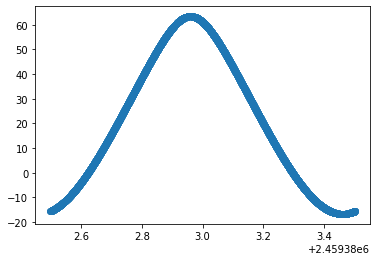

In [64]:
#plt.scatter(eph["datetime_jd"], eph["DEC"])
#plt.scatter(eph["datetime_jd"], eph["DEC_app"])

plt.scatter(eph["datetime_jd"], eph["EL"])
RT2_location = EarthLocation(lat=49.90859805061835*u.deg, lon=14.779752713599184*u.deg, height=512*u.m)


In [ ]:
plt.scatter(eph["datetime_jd"], eph["RA_app"])

# SIMBAD

For SIMBAD objects, we download only RA and DEC.
This querry takes about 1.2 seconds on my network, 
from the jupyter environment.

To time a jupyter notebook cell, type %%time on the first line of the cell

In [7]:
# query simbad for deep sky objects and stars

# in the same format as SIMBAD accpets on their website
obj_name = "Cas A"
dso = SkyCoord.from_name(obj_name)
RT2_location = EarthLocation(lat=49.90859805061835*u.deg, lon=14.779752713599184*u.deg, height=512*u.m)

CPU times: user 22 ms, sys: 3.56 ms, total: 25.6 ms
Wall time: 1.33 s


Transforming the coordinates for 86400 seconds in a day
takes quite long, about 20 seconds on my PC. Probably unnecessary precision,
probably handling the geographic corrections in a non-economic way. I'll
try to find a better way.

In [8]:
time = JDs
coords = dso.transform_to(AltAz(obstime=time, location=RT2_location))

coords

CPU times: user 25.3 s, sys: 54.4 ms, total: 25.4 s
Wall time: 25.3 s


<SkyCoord (AltAz: obstime=[datetime.datetime(2021, 6, 19, 0, 0)
 datetime.datetime(2021, 6, 19, 0, 0, 1)
 datetime.datetime(2021, 6, 19, 0, 0, 2) ...
 datetime.datetime(2021, 6, 19, 23, 59, 57)
 datetime.datetime(2021, 6, 19, 23, 59, 58)
 datetime.datetime(2021, 6, 19, 23, 59, 59)], location=(3979793.72277795, 1050002.43547712, 4856639.63508028) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    [(49.63241871, 50.80995727), (49.63347739, 50.81200736),
     (49.63453595, 50.81405748), ..., (49.87589432, 51.28821423),
     (49.87692707, 51.29027171), (49.87795971, 51.29232921)]>

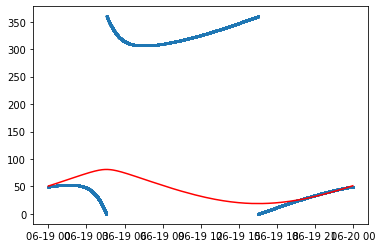

In [14]:
AZ = coords.az.to_string(decimal=True)
AZ = AZ.astype("float")

EL = coords.alt.to_string(decimal=True)
EL = EL.astype("float")


plt.scatter(epochs, AZ, s=1)
plt.plot(epochs, EL, c="r")

In [ ]:
alt_strings = alts.to_string(decimal=True)
alt_strings.astype("float")

In [85]:
def generate_eph_file(time, EL, AZ, name="AzEl_file.txt", jd=False):
    # time in datetime string "YYYY-MM-DD hh:mm:ss" or jd,
    # but must be specified
    with open(name, "w+") as f:
        if jd:
            for i, t in enumerate(time):
                f.write(f"{julian.from_jd(t)} {EL[i]} {AZ[i]}\n")
        else:
            for i, t in enumerate(time):
                f.write(f"{t} {EL[i]} {AZ[i]}\n")

In [83]:
generate_eph_file(time, EL, AZ, name="CasA.txt")

In [84]:
generate_eph_file(larger_time_axis, interpolated_EL, interpolated_AZ, name="SUN_ephem.txt", solar_system=True)

In [92]:
class Ephemeris:
    def __init__(self, name, start, stop, solar_system=False, precision=4000):
        self.name = name
        self.start = start
        self.stop = stop
        self.solar_system = solar_system
        
        # you can change the precision value
        # 5000 seems to be the upper limit,
        # and 4000 takes ~ 10 seconds to download
        self.precision = precision
        
        # for RT2
        self.location = EarthLocation(lat=49.90859805061835*u.deg, lon=14.779752713599184*u.deg, height=512*u.m)

        # generate time based on database requirements
        self.time_generation()
        
        if self.solar_system:
            self.jpl_horizons()
        else:
            self.simbad()
            
    def _time_generation(self):
        if self.solar_system:
            
            # generate time dictionary for JPL Horizons
            self._internal_time = {start: self.start, end:self.stop, step: self.precision}
        else:
            dt = datetime.timedelta(seconds=1)
    
    
    
    def _simbad(self):
        # search simbad for name
        dso = SkyCoord.from_name(self.name)

In [95]:
E = Ephemeris("Cas A", 0, 1)
